## TOC:
* [Reading CVS files](#first-bullet)
* [Luminosity section](#second-bullet)
* [Trigger rate section](#third-bullet)
* [Model training section](#fourth-bullet)

In [1]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc
import datetime
from datetime import timedelta

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, AveragePooling1D,\
UpSampling1D, InputLayer

from scipy import ndimage, misc

from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.externals import joblib
#from sklearn.neighbors import LocalOutlierFactor
from sklearn import cluster, datasets

Using TensorFlow backend.


In [28]:
from pandas.tseries import converter
converter.register() 

In [2]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

In [3]:
import os
cwd = os.getcwd()
print cwd

/eos/user/c/calabria/Merve/DTTriggerRateMonitoringWithML


In [6]:
runs = [297179, 297180, 297181]
lumi_directory = "./lumi"
rates_directory = "./rates"
runs_ref = [306125]
lumi_directory_ref = "/eos/user/c/calabria/DTTriggerRateMonitoringWithML/lumi"
rates_directory_ref = "/eos/user/c/calabria/DTTriggerRateMonitoringWithML/rates"

# Reading cvs files <a class="anchor" id="first-bullet"></a>

Reading instantaneous luminosities from the cvs file produced with brilcalc and saving into a pandas dataframe:

In [7]:
df_rates = pd.DataFrame()
int_lumi2 = pd.DataFrame()
for run in runs:
    print("Loading %s" % run)
    path = "%s/lumi_%s.csv" % (lumi_directory, run)
    int_lumi2 = int_lumi2.append(pd.read_csv(path,
        names=["runfill", "ls", "time", "beamstatus", "energy", "delivered",\
               "recorded", "avgpu", "source"]), 
        ignore_index=True);    
    path = "%s/dt_rates_%s.csv" % (rates_directory, run)
    df_rates = df_rates.append(pd.read_csv(path, 
        names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4",\
               "DT1", "DT2", "DT3", "DT4", "DT5"]), 
        ignore_index=True);
print("Done.")

Loading 297179
Loading 297180
Loading 297181
Done.


In [8]:
for run in runs_ref:
    print("Loading %s" % run)
    path = "%s/lumi_%s.csv" % (lumi_directory_ref, run)
    int_lumi2 = int_lumi2.append(pd.read_csv(path,
        names=["runfill", "ls", "time", "beamstatus", "energy", "delivered",\
               "recorded", "avgpu", "source"]), 
        ignore_index=True);    
    path = "%s/dt_rates_%s.csv" % (rates_directory_ref, run)
    df_rates = df_rates.append(pd.read_csv(path, 
        names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4",\
               "DT1", "DT2", "DT3", "DT4", "DT5"]), 
        ignore_index=True);
print("Done.")

Loading 306125
Done.


# Luminosity section <a class="anchor" id="second-bullet"></a>

Dropping useless rows inherited from the lumi CVS file:

In [9]:
int_lumi2["source"] = int_lumi2["source"].astype('str')
int_lumi2 = int_lumi2[int_lumi2["source"] != "nan"]
int_lumi2 = int_lumi2[int_lumi2["source"] != "source"]

Splitting run:fill field and the start and end lumi sections:

In [10]:
int_lumi2['run'], int_lumi2['fill'] = int_lumi2['runfill'].str.split(':', 1).str
int_lumi2['ls_start'], int_lumi2['ls_end'] = int_lumi2['ls'].str.split(':', 1).str

Converting run to integer and luminosities to float:

In [11]:
int_lumi2["run"] = int_lumi2["run"].astype('int')
int_lumi2["ls_start"] = int_lumi2["ls_start"].astype('int')
int_lumi2["ls_end"] = int_lumi2["ls_end"].astype('int')
int_lumi2["delivered"] = int_lumi2["delivered"].astype('float64')
int_lumi2["recorded"] = int_lumi2["recorded"].astype('float64') 

Converting time stamp to datetime:

In [12]:
def transform_time(data):
    from datetime import datetime
    time_str = data.time
    #print time_str
    datetime_object = datetime.strptime(time_str, "%m/%d/%y %H:%M:%S")
    #print datetime_object
    return datetime_object
int_lumi2["time"] = int_lumi2.apply(transform_time, axis=1);

Creating end time column from the start time:

In [13]:
int_lumi2["time_end"] = int_lumi2["time"]

Finding the runs and their start and end times:

In [15]:
boundaries = pd.DataFrame(columns=["run", "start", "end", "ls_start", "ls_end", "nLS"])
for i in runs+runs_ref:
    start = int_lumi2[int_lumi2["run"] == i]["time"]
    end = int_lumi2[int_lumi2["run"] == i]["time_end"]
    start_ls = int_lumi2[int_lumi2["run"] == i]["ls_start"]
    end_ls = int_lumi2[int_lumi2["run"] == i]["ls_end"]
    start =  start.reset_index(drop=True)
    end =  end.reset_index(drop=True)
    start_ls =  start_ls.reset_index(drop=True)
    end_ls =  end_ls.reset_index(drop=True)
    nLS = int(start_ls.iloc[-1]) - int(start_ls.iloc[0]) + 1
    print i, start.iloc[0], start.iloc[-1], start_ls.iloc[0], start_ls.iloc[-1], nLS
    boundaries = boundaries.append({"run": i, "start": start.iloc[0], "end": start.iloc[-1], 
                                   "ls_start": start_ls.iloc[0], "ls_end": start_ls.iloc[-1],\
                                    "nLS": nLS}, ignore_index = True)

297179 2017-06-20 07:09:38 2017-06-20 07:49:39 1 104 104
297180 2017-06-20 07:49:56 2017-06-20 08:43:55 1 140 140
297181 2017-06-20 08:44:01 2017-06-20 09:20:32 1 95 95
306125 2017-11-03 14:46:12 2017-11-04 10:14:06 1 3007 3007


In [16]:
boundaries = boundaries.sort_values('run')
boundaries = boundaries.reset_index()

Reindexing the dataframe after removing some lines:

In [17]:
int_lumi2.index = pd.RangeIndex(len(int_lumi2.index))

In [18]:
print len(int_lumi2.index)

3346


Filling end time column:

In [19]:
def addTimeOffSet(startdate):
    enddate = pd.to_datetime(startdate) + pd.DateOffset(seconds=23)
    return enddate

def shiftElement(df, boundaries):
    run0 = boundaries["run"].iloc[0]
    for index, rows in df.iterrows():
        run = rows["run"]
        nls = int(boundaries[boundaries["run"] == run]["nLS"])
        if(run > run0):
            nls = nls + index
        #print run, nls
        if((index < nls) & (index < len(int_lumi2.index)-1)):
            #print index, run, rows["time"], df["time"][index+1]
            df.loc[index, "time_end"] = df["time"][index+1]
        elif (index == len(int_lumi2.index)-1):
            #print index, run, rows["time"], addTimeOffSet(rows["time"])
            df.loc[index, "time_end"] = addTimeOffSet(rows["time"])
                    
shiftElement(int_lumi2, boundaries)

Selecting only beam status STABLE BEAM:

In [20]:
#print int_lumi2["beamstatus"]
int_lumi2 = int_lumi2[int_lumi2["beamstatus"] == "STABLE BEAMS"]

In [21]:
int_lumi2.to_csv("int_lumi2.csv", sep='\t')

Plotting the instantaneous luminosities:

In [22]:
def plot_inst_lumi(x_val, y_val, z_val, title):
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel(r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]")
    xfmt = mdates.DateFormatter('%y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(x_val, y_val, 'ro-')
    plt.plot(x_val, z_val, 'bo-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();

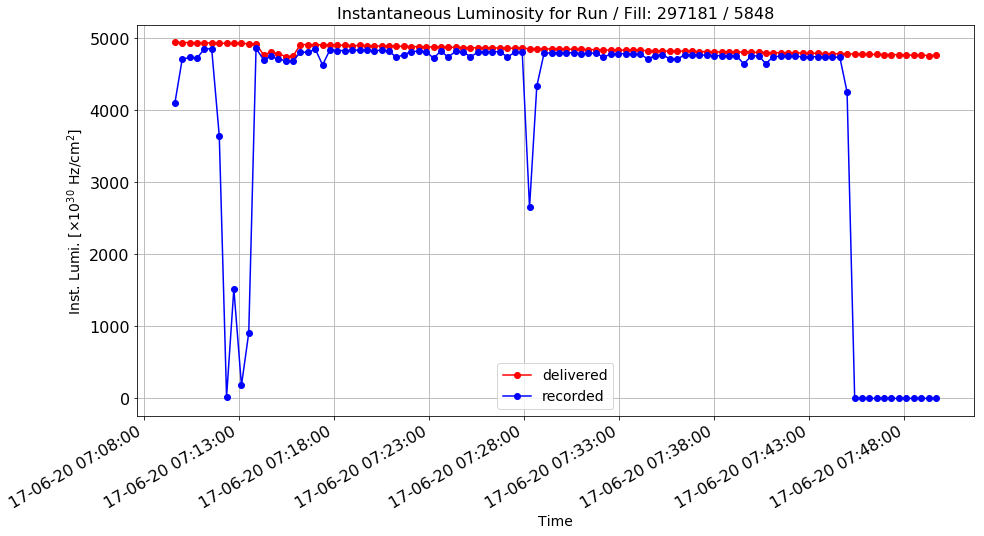

In [29]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 297179]["time"], 
               int_lumi2[int_lumi2["run"] == 297179]["delivered"], 
               int_lumi2[int_lumi2["run"] == 297179]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               ("297181", int_lumi2["fill"].iloc[0])))

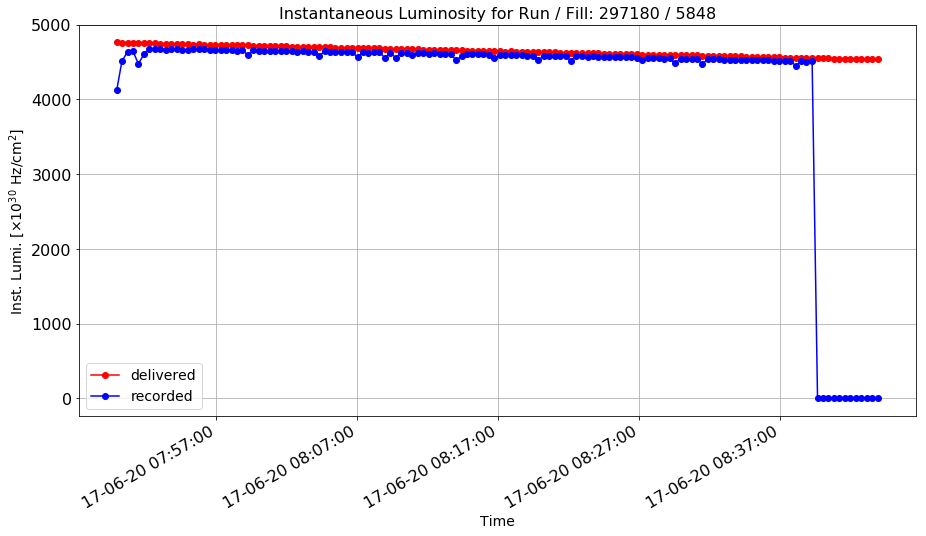

In [34]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 297180]["time"], 
               int_lumi2[int_lumi2["run"] == 297180]["delivered"], 
               int_lumi2[int_lumi2["run"] == 297180]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               ("297180", int_lumi2["fill"].iloc[0])))

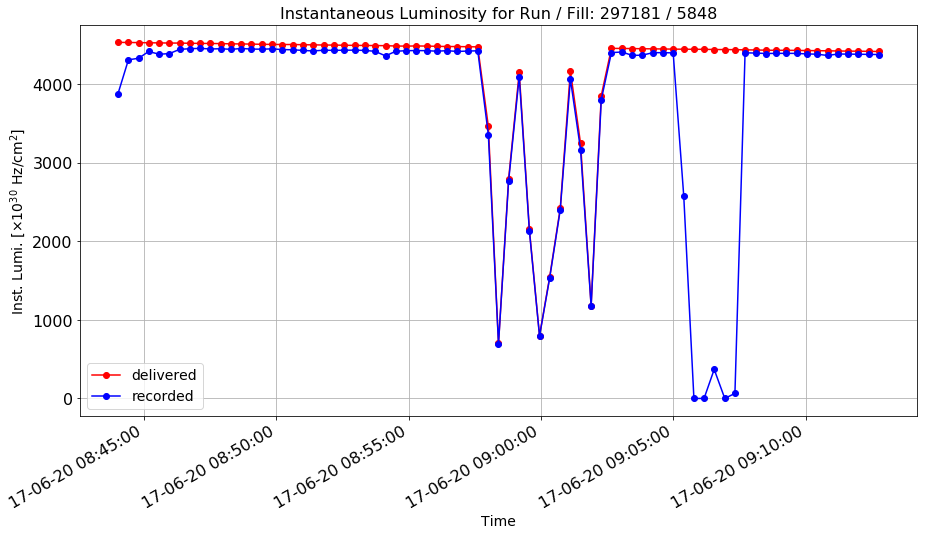

In [33]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 297181]["time"], 
               int_lumi2[int_lumi2["run"] == 297181]["delivered"], 
               int_lumi2[int_lumi2["run"] == 297181]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               ("297181", int_lumi2["fill"].iloc[0])))

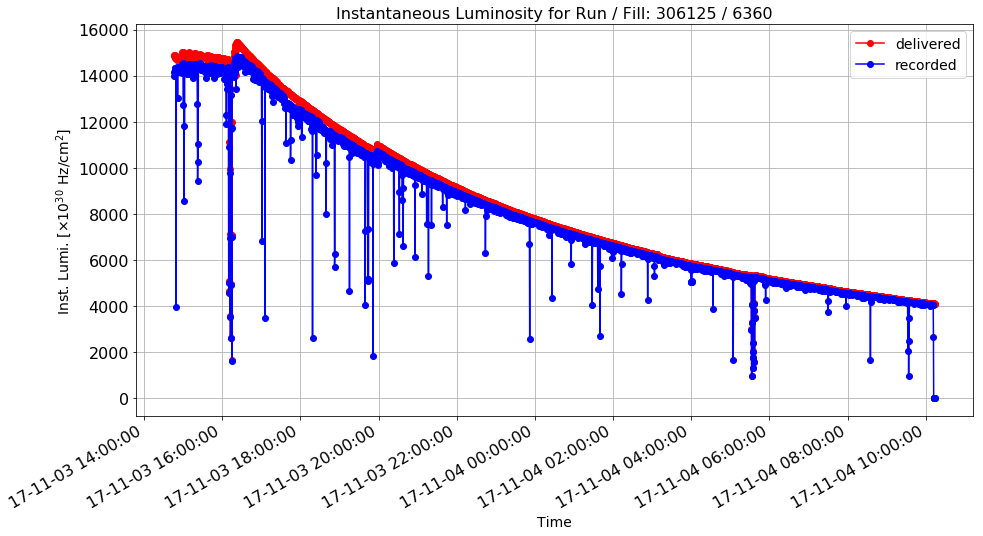

In [36]:
plot_inst_lumi(int_lumi2[int_lumi2["run"] == 306125]["time"], 
               int_lumi2[int_lumi2["run"] == 306125]["delivered"], 
               int_lumi2[int_lumi2["run"] == 306125]["recorded"], 
               ("Instantaneous Luminosity for Run / Fill: %s / %s" % 
               ("306125", int_lumi2[int_lumi2.run == 306125]["fill"].iloc[0])))

# Trigger rate section <a class="anchor" id="third-bullet"></a>

Converting columns to proper data types:

In [37]:
df_rates["time"] = pd.to_datetime(df_rates["time"])
df_rates["run"] = df_rates["run"].astype('int')
#print df_rates["time"]

Splitting, converting and adding new columns:

In [38]:
df_rates['wheel'], df_rates['sector'] = df_rates['board'].str.split('_', 1).str
df_rates["wheel"] = df_rates["wheel"].astype(str)
df_rates["sector"] = df_rates["sector"].astype(str)

In [40]:
df_rates["wheel"].replace(regex=True,inplace=True,to_replace=r'YB',value=r'')
df_rates["sector"].replace(regex=True,inplace=True,to_replace=r'S',value=r'')
df_rates["wheel"] = df_rates["wheel"].astype('int')
df_rates["sector"] = df_rates["sector"].astype('int')
df_rates["ls"] = -1
df_rates["lumi"] = -1.0
df_rates["score"] = -1
df_rates.to_csv("df_rates.csv", sep='\t')

Plotting the rate coming from one of the stations:

In [43]:
def plot_rate_vs_time(df, x_val, y_val, z_val, title):
    df_temp = df.copy()
    crit = df_temp["board"] == z_val
    df_temp = df_temp[crit]
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Rate [Hz]")
    ax.xaxis_date()
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], 'ro-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

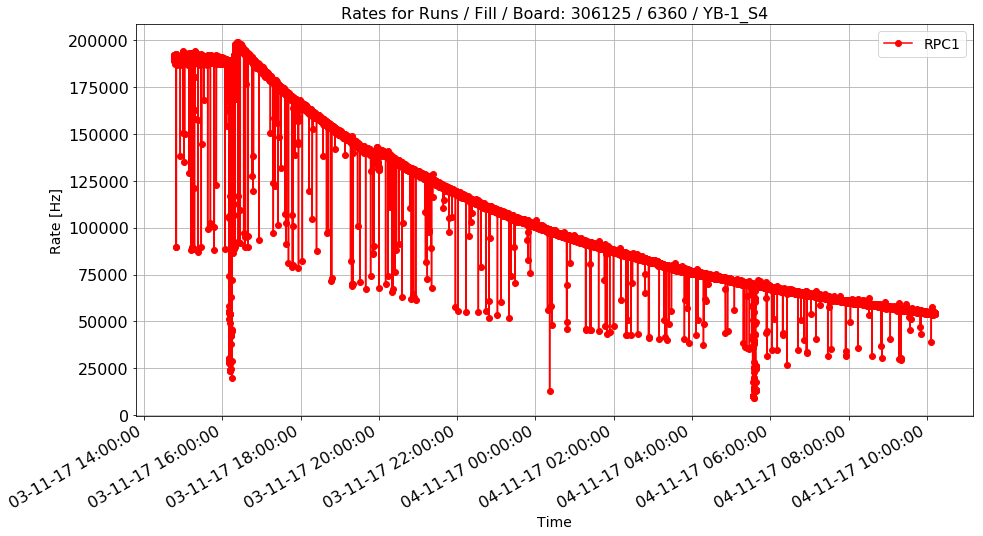

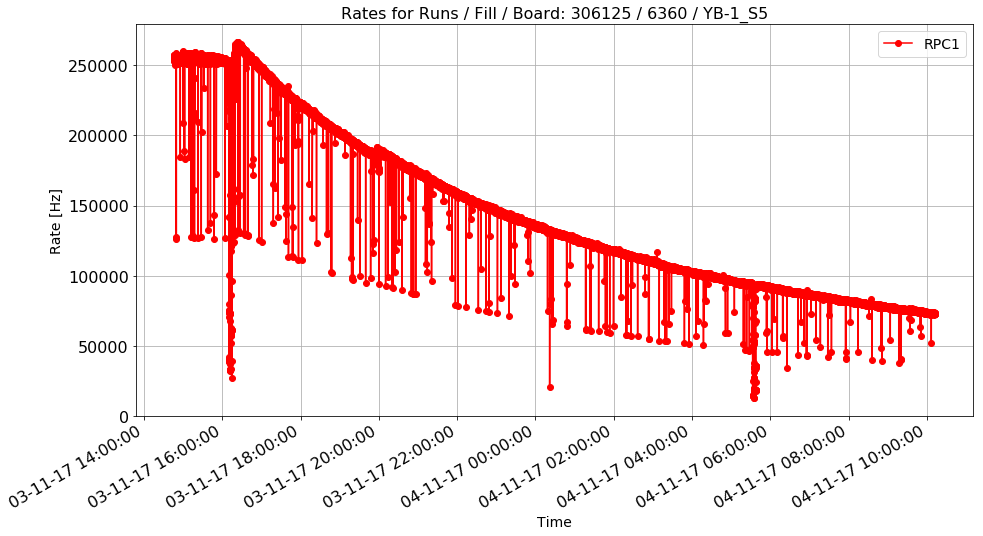

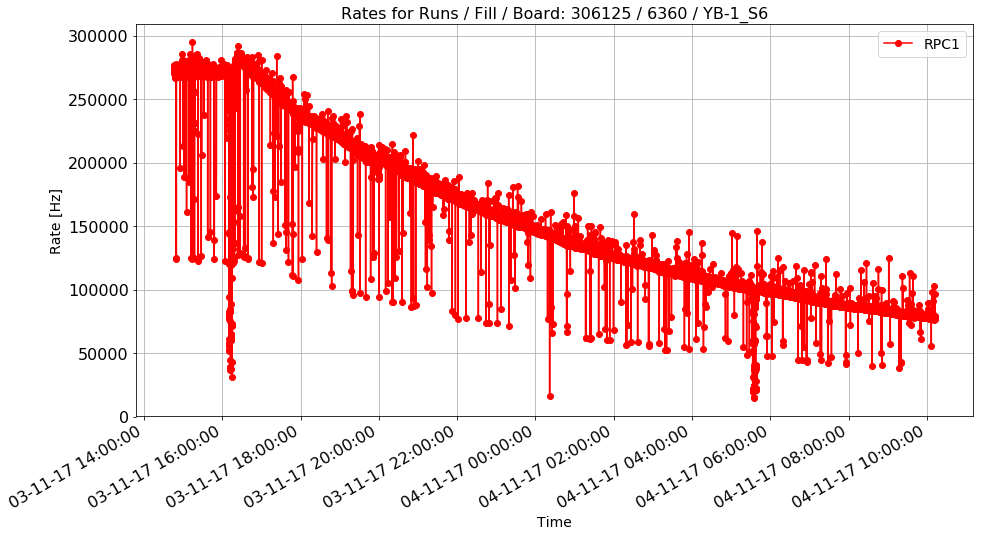

In [44]:
rule = (df_rates.run == 306125)
boards = ["YB-1_S4", "YB-1_S5", "YB-1_S6"]
for board in boards:
    plot_rate_vs_time(df_rates[rule],\
                      "time", "RPC1", board, "Rates for Runs / Fill / Board: %s / %s / %s" % 
                      ("306125", int_lumi2[int_lumi2.run == 306125]["fill"].iloc[0], board))

Associating a LS and an instantaneous luminosity to each rate:

In [45]:
#Just a backup copy
df_rates_backup = df_rates.copy()

In [46]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

Removing the measurements taken before and after the start and end time reported by the brilcalc output. All the 60 boards are measured at the same time. In order to speed-up the association, we take just one board, the first one. This reduces the dataframe and the time needed to go though it by a factor of 60.

In [47]:
time0 = boundaries["start"].iloc[0]
timeF = boundaries["end"].iloc[-1]
print time0, timeF
#print df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
df_rates = df_rates[(df_rates.time >= time0) & (df_rates.time <= timeF)]
rule = df_rates.duplicated(subset=["time"])
count = (rule == False).sum()
print "Duplicates:", rule.sum()
df_rates_noduplicates = df_rates[rule == False]
#print df_rates_noduplicates

2017-06-20 07:09:38 2017-11-04 10:14:06
Duplicates: 1294283


In [48]:
print len(df_rates_noduplicates)

21937


Assigning the LS and the inst. lumi. to the measurements for the selected board:

In [49]:
def assignLS(df1, df2, boundaries):
    temp = df1.copy()
    j = 1
    for index1, row1 in df1.iterrows():
        run1 = row1["run"]
        time1 = row1["time"]
        #print index1, run1, time1
        ti = time1 - 2*pd.DateOffset(seconds=23)
        tf = time1 + 2*pd.DateOffset(seconds=23)
        indexes2 = df2[(df2.run == run1) & (df2.time > ti) & (df2.time < tf)].index
        #print indexes2
        for i in indexes2:
            if((time1 >= df2["time"].loc[i]) & (time1 < df2["time_end"].loc[i])):
                #print time1, df2["time"].loc[i], df2["time_end"].loc[i]
                if(j%1000 == 0): 
                    print j
                j = j + 1
                ls = df2["ls_start"].loc[i]
                lumi = df2["delivered"].loc[i]
                #print index1, run1, time1, ls, lumi
                temp.loc[index1, "ls"] = ls
                temp.loc[index1, "lumi"] = lumi
                break
    return temp

temp = assignLS(df_rates_noduplicates, int_lumi2, boundaries)
df_rates_noduplicates = temp

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000


Removing the few cases not assigned and that are still at -1:

In [50]:
df_rates_noduplicates = df_rates_noduplicates[df_rates_noduplicates["ls"] > 0]
print len(df_rates_noduplicates)

21929


Save in a csv file:

In [51]:
df_rates.to_csv("df_rates.csv", sep='\t')
df_rates_noduplicates.to_csv("df_rates_nodup.csv", sep='\t')

In [52]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

Assign the LS and the inst. lumi. to all the 60 boards for each time:

In [53]:
def assignLS_ext(df1, df2):
    temp = df1.copy()
    indexes = []
    for index in df2.index:
        if index%10000 == 0:
            print index
        time = df2["time"].loc[index]
        ls = df2["ls"].loc[index]
        lumi = df2["lumi"].loc[index]
        des = (temp["time"] == time)
        indexes = temp[des].index
        #print time, ls, indexes
        temp.loc[des, "ls"] = ls
        temp.loc[des, "lumi"] = lumi
    return temp
    
temp = assignLS_ext(df_rates, df_rates_noduplicates)

30000
60000
90000
120000
150000
180000
210000
240000
270000
300000
330000
360000
390000
420000
450000
480000
510000
540000
570000
600000
630000
660000
690000
720000
750000
780000
810000
840000
870000
900000
930000
960000
990000
1020000
1050000
1080000
1110000
1140000
1170000
1200000
1230000
1260000
1290000


In [54]:
df_rates = temp.copy()
#print df_rates[df_rates.ls <= 0]

Removing measurements without LS assignment:

In [55]:
df_rates_backup = df_rates.copy()
df_rates = df_rates[df_rates.ls > 0]
#print df_rates["ls"]

In [56]:
#print df_rates[df_rates.ls <= 0]
df_rates.to_csv("df_rates.csv", sep='\t')

Averaging the rates associated to the same LS:

In [57]:
df_boards = df_rates.copy()
df_boards = df_boards.groupby(['board']).size().reset_index(name='counts')
print len(df_boards)
#print df_boards

60


Too slow to use all the measurements. Averaging over 10 LS:

In [58]:
#Uncomment to restore backup copy
#df_rates = df_rates_backup.copy()

In [59]:
bunch = 10
def assignGroup(data, div = bunch):
    res = int(data/div)
    #print data, res
    return res

df_rates["group"] = df_rates["ls"]
df_rates["group"] = df_rates["group"].apply(assignGroup)

In [60]:
#print df_rates["group"]

In [61]:
temp1 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["ls", "lumi", "RPC1", "RPC2", "RPC3", "RPC4",\
  "DT1", "DT2", "DT3", "DT4", "DT5"]].mean().reset_index()

temp2 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["lumi", "RPC1", "RPC2", "RPC3", "RPC4",\
  "DT1", "DT2", "DT3", "DT4", "DT5"]].std().reset_index()

temp3 = df_rates.groupby(['run', 'group', 'board', 'wheel', 'sector'])\
[["lumi", "RPC1", "RPC2", "RPC3", "RPC4",\
  "DT1", "DT2", "DT3", "DT4", "DT5"]].size().reset_index(name='counts')

temp2 = temp2.rename(index=str, columns={"lumi": "errLumi", "RPC1": "errRPC1", "RPC2": "errRPC2",\
                                         "RPC3": "errRPC3", "RPC4": "errRPC4", "DT1": "errDT1",\
                                         "DT2": "errDT2", "DT3": "errDT3", "DT4":\
                                         "errDT4", "DT5": "errDT5"})

cols_to_use2 = temp2.columns.difference(temp1.columns)
cols_to_use3 = temp3.columns.difference(temp1.columns)

temp2 = temp2[cols_to_use2]
temp3 = temp3[cols_to_use3]

#print temp1.iloc[100]
#print temp2.iloc[100]
#print temp3.iloc[100]

temp1.reset_index(drop=True, inplace=True)
temp2.reset_index(drop=True, inplace=True)
temp3.reset_index(drop=True, inplace=True)

df_rates = pd.concat([temp1, temp2, temp3], axis = 1)

Calculating the errors on the mean values calculated in the previous step:

In [62]:
import math
def applySqrt(data):
    return math.sqrt(data)

df_rates["counts"] = df_rates["counts"].apply(applySqrt)

for i in list(df_rates):
    if "err" in i:
        #print i
        df_rates[i] = df_rates[i]/df_rates["counts"]

In [63]:
#print df_rates

Check for null or NaN values:

In [64]:
print df_rates.isnull().values.any()
null_columns=df_rates.columns[df_rates.isnull().any()]
print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())
#df_rates = df_rates.fillna(0)
#print(df_rates[df_rates.isnull().any(axis=1)][null_columns].head())

False
Empty DataFrame
Columns: []
Index: []


In [65]:
#Another backup
#df_rates_backup = df_rates.copy()
df_rates.to_csv("df_rates.csv", sep='\t')

In [66]:
#Restore backup
#df_rates = df_rates_backup.copy()

In [67]:
print len(df_rates)

19920


Uncomment to check just one case case:

In [68]:
#for index, row in df_rates.iterrows():
    #if row["board"] == "YB0_S1":
        #print "Index:", index,", Run:", row["run"],", Board: ",row["board"],",\
        #LS: ",row["ls"],", Rate: ",row["DT1"],", Error: ",row["errDT1"]

Plotting the result:

In [69]:
def plot_rate_vs_ls(df, run, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt):
    df_temp = df.copy()
    rule = ((df_temp["board"] == z_val) & (df_temp["run"] == run))
    df_temp = df_temp[rule]
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], opt)
    plt.legend(loc="best")
    plt.errorbar(df_temp[x_val], df_temp[y_val], xerr=x_err, yerr=df_temp[y_err], fmt='ro', ecolor='r')
    plt.title(title)
    plt.show()

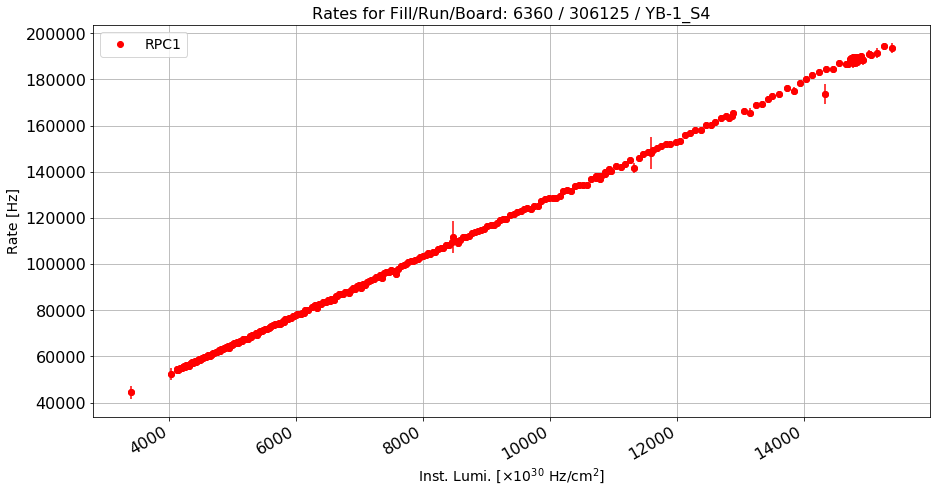

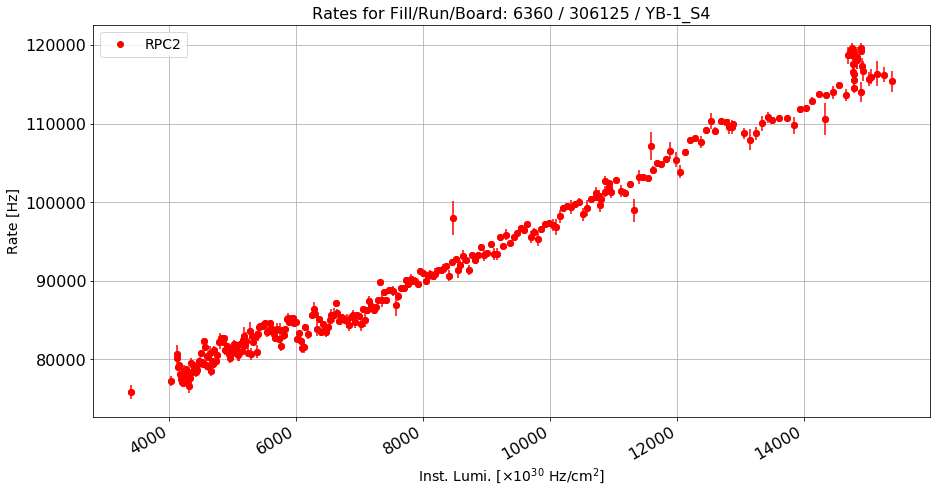

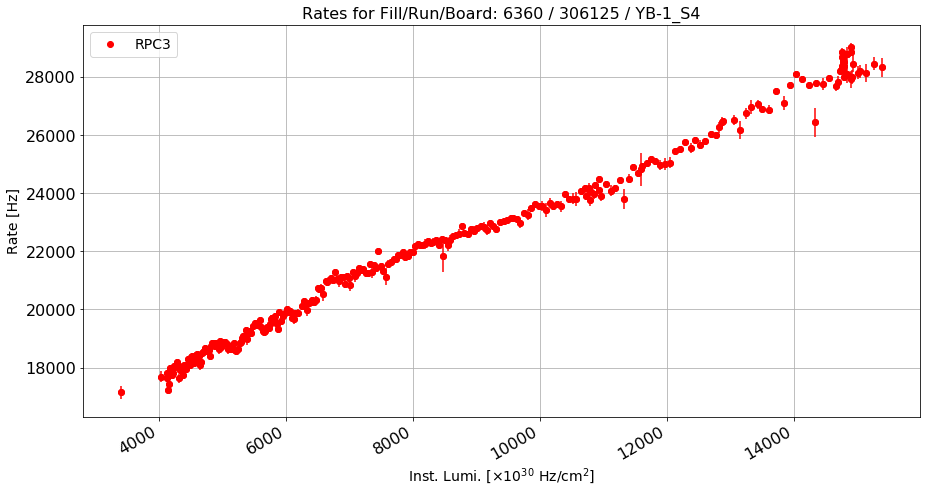

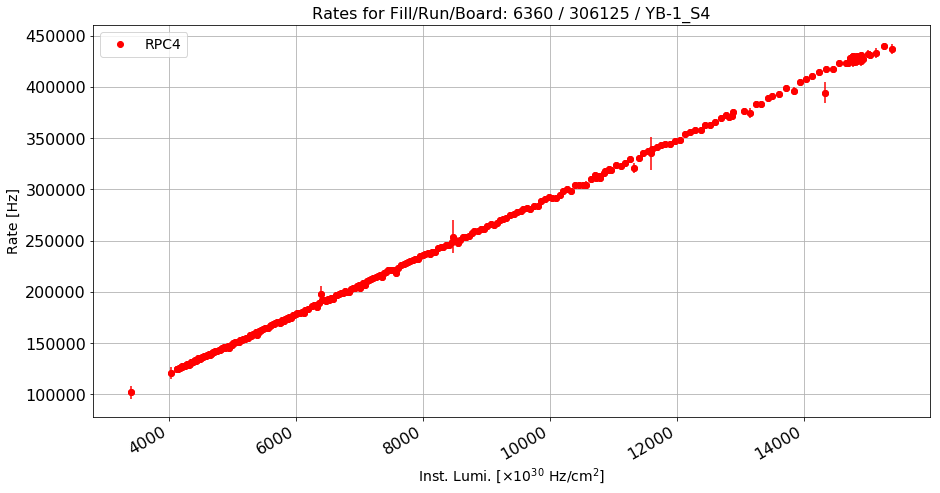

In [78]:
boards = ["YB-1_S4", "YB-1_S5", "YB-1_S6"]    
    
title = "Rates for Fill/Run/Board: "+str(int_lumi2[int_lumi2.run == 306125]["fill"].iloc[0])+" / "\
+str(boundaries["run"].iloc[3])+" / YB-1_S4"

plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC1", "YB-1_S4", 0, "errRPC1",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC2", "YB-1_S4", 0, "errRPC2",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC3", "YB-1_S4", 0, "errRPC3",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls(df_rates, 306125, "lumi", "RPC4", "YB-1_S4", 0, "errRPC4",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]",\
                "Rate [Hz]", title, "ro")

Create a new dataframe with the input features already organized in a numpy array:

In [71]:
print len(df_rates)
algos = ['RPC1', 'RPC2', 'RPC3', 'RPC4']
df_rates_new_2 = pd.DataFrame(columns=['run', 'group', 'board', 'wheel', 'sector', 'ls',\
                                     'lumi', 'errLumi', 'rate', 'err', 'system', 'station'])

for i in algos:
    list_a = ['run', 'group', 'board', 'wheel', 'sector', 'ls', 'lumi', 'errLumi', i, 'err'+i,]
    temp = df_rates.copy()
    temp = temp[list_a]
    temp["system"] = -1
    temp["station"] = -1
    j = i
    if (i.find("RPC") != -1):
        temp["system"] = 1
        num = i.replace("RPC", "")
        temp["station"] = int(num)
    else:
        temp["system"] = 2
        num = i.replace("DT", "")
        temp["station"] = int(num)
    temp = temp.rename(columns={j: 'rate', 'err'+j: 'err'})
    #print temp.columns
    df_rates_new_2 = pd.concat([df_rates_new_2, temp], ignore_index=True)

print len(df_rates_new_2)

19920
79680


Adding the lumi/rate ratio:

In [151]:
df_rates_new_2["CS"] = -1
df_rates_new_2["errCS"] = -1

df_rates_new_2["CS"] = df_rates_new_2["rate"]/df_rates_new_2["lumi"]
print "Number of NaN's in CS before:"
print len(df_rates_new_2["CS"][df_rates_new_2["CS"].isnull() == True])
print "Number of Inf's in CS before:"
print len(df_rates_new_2["CS"][np.isinf(df_rates_new_2["CS"])])

df_rates_new_2["CS"] = df_rates_new_2["CS"].replace([np.inf, -np.inf], np.nan)
df_rates_new_2["CS"] = df_rates_new_2["CS"].fillna(-1)

print "Number of NaN's in CS after:"
print len(df_rates_new_2["CS"][df_rates_new_2["CS"].isnull() == True])
print "Number of Inf's in CS after:"
print len(df_rates_new_2["CS"][np.isinf(df_rates_new_2["CS"])])

df_rates_new_2["errCS"] = (1/df_rates_new_2["lumi"])*\
np.sqrt(df_rates_new_2["err"]**2 + df_rates_new_2["CS"]**2 * df_rates_new_2["errLumi"]**2)

print "Number of NaN's in errCS before:"
print len(df_rates_new_2["errCS"][df_rates_new_2["errCS"].isnull() == True])
print "Number of Inf's in errCS before:"
print len(df_rates_new_2["errCS"][np.isinf(df_rates_new_2["errCS"])])

df_rates_new_2["errCS"] = df_rates_new_2["errCS"].replace([np.inf, -np.inf], np.nan)
df_rates_new_2["errCS"] = df_rates_new_2["errCS"].fillna(-1)

print "Number of NaN's in errCS after:"
print len(df_rates_new_2["errCS"][df_rates_new_2["errCS"].isnull() == True])
print "Number of Inf's in errCS after:"
print len(df_rates_new_2["errCS"][np.isinf(df_rates_new_2["errCS"])])

Number of NaN's in CS before:
0
Number of Inf's in CS before:
0
Number of NaN's in CS after:
0
Number of Inf's in CS after:
0
Number of NaN's in errCS before:
0
Number of Inf's in errCS before:
0
Number of NaN's in errCS after:
0
Number of Inf's in errCS after:
0


In [152]:
array = df_rates_new_2.as_matrix(columns=['system', 'wheel', 'sector', 'station',\
                                        'lumi', 'errLumi', 'rate', 'err',\
                                        'CS', 'errCS'])

In [153]:
df_rates_new_2["content"] = np.empty((len(df_rates_new_2), 0)).tolist()
for index, rows in df_rates_new_2.iterrows():
    #print index, array[index]
    df_rates_new_2.at[index, "content"] = array[index]
df_rates_new_2["score"] = -1

Check if the two dataframes are exactly the same:

In [181]:
def plot_rate_vs_ls_2(df1, df2, x_val, y_val, x_err, y_err, title_x, title_y, title, opt, log = False):
    fig, ax = plt.subplots()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    if log:
        ax.set_yscale('log')
    plt.errorbar(df1[x_val], df1[y_val], xerr=x_err, yerr=df1[y_err], fmt='ro', ecolor='r')
    num = y_val
    num = num.replace("RPC", "")
    tmp = df2[df2.station == int(num)]
    plt.errorbar(tmp[x_val], tmp["rate"], xerr=x_err, yerr=tmp["err"], fmt='b+', ecolor='b')
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

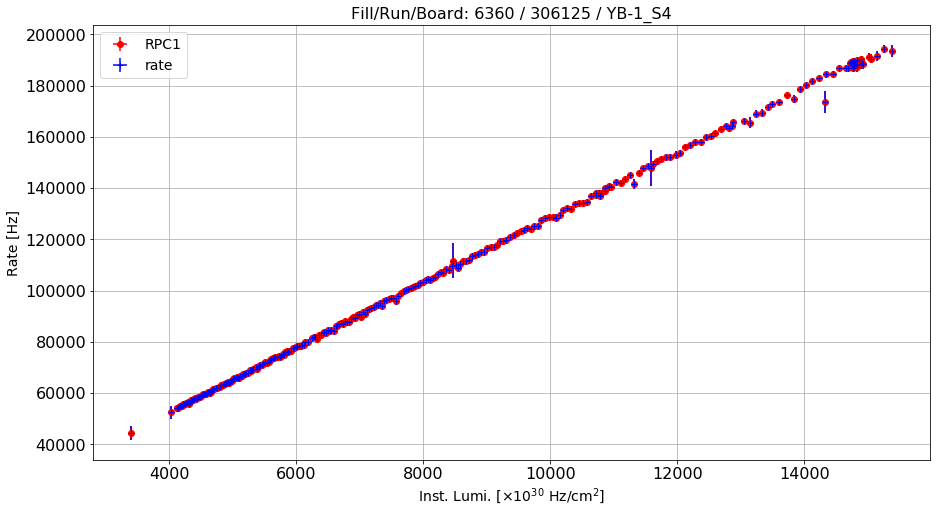

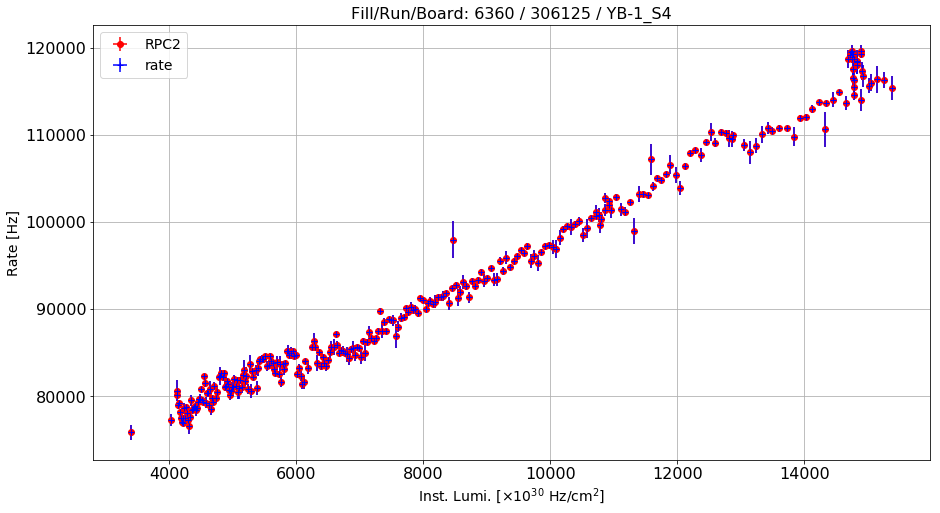

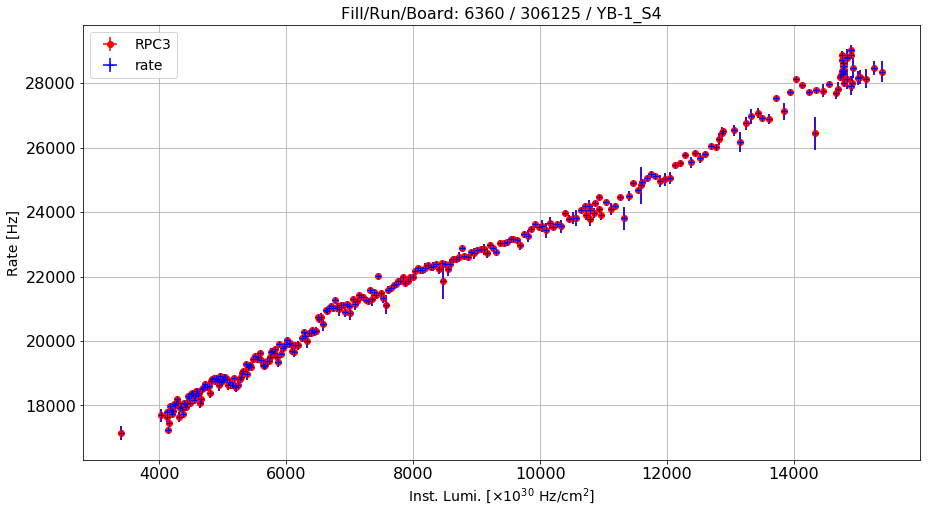

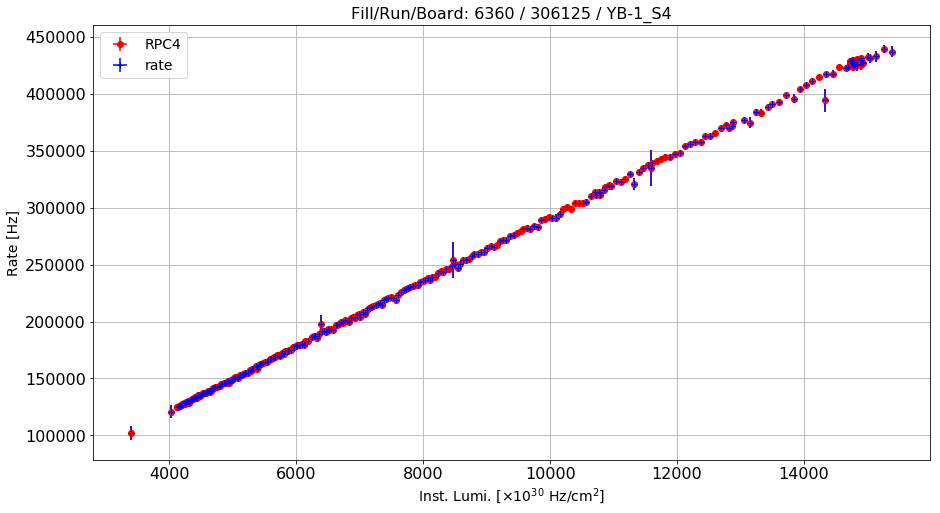

In [183]:
title = "Fill/Run/Board: "+str(int_lumi2[int_lumi2.run == 306125]["fill"].iloc[0])+\
" / "+str(boundaries["run"].iloc[3])+" / YB-1_S4"

rule_1 = ((df_rates["wheel"] == -1) & (df_rates["sector"] == 4) & (df_rates["run"] == 306125))
rule_2 = ((df_rates_new_2["wheel"] == -1) & (df_rates_new_2["sector"] == 4)\
          & (df_rates_new_2["run"] == 306125))

temp1 = df_rates[rule_1]
temp2 = df_rates_new_2[rule_2]

plot_rate_vs_ls_2(temp1, temp2, "lumi", "RPC1", 0, "errRPC1", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "lumi", "RPC2", 0, "errRPC2", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "lumi", "RPC3", 0, "errRPC3", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "lumi", "RPC4", 0, "errRPC4", r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Rate [Hz]", title, "ro")

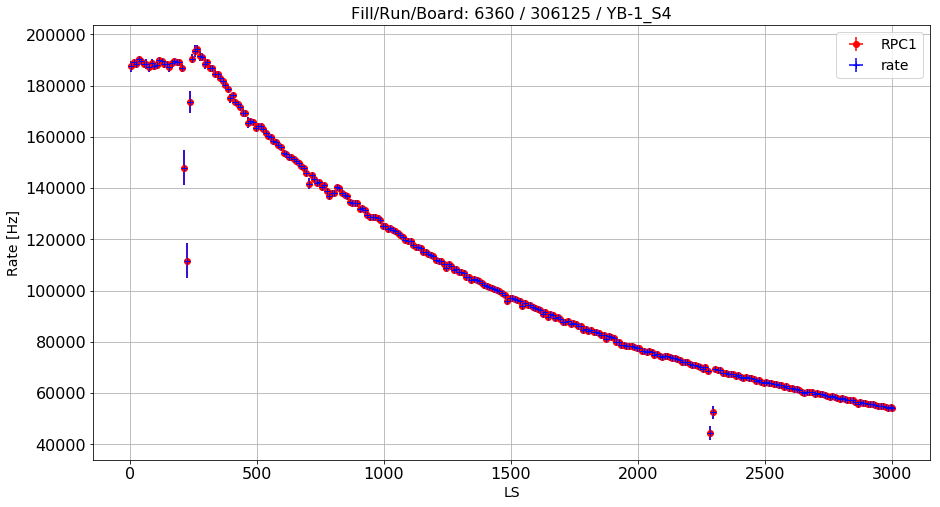

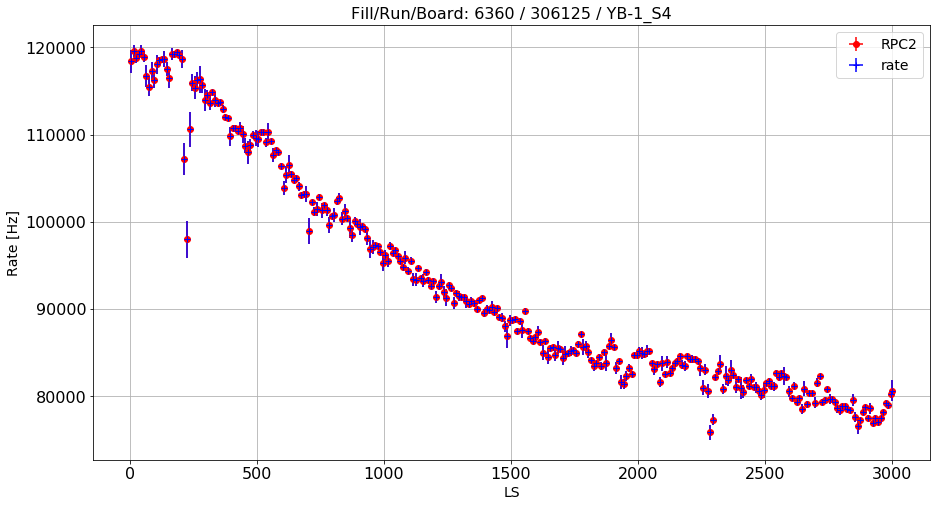

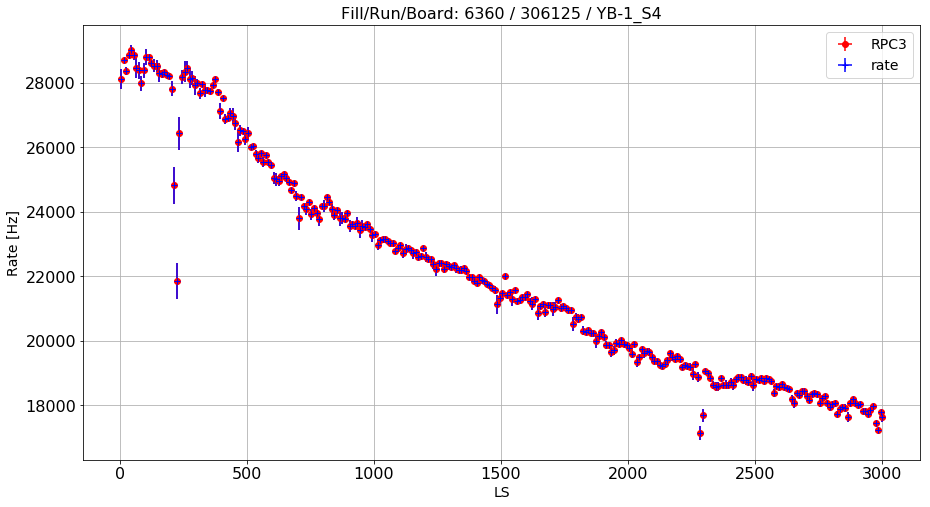

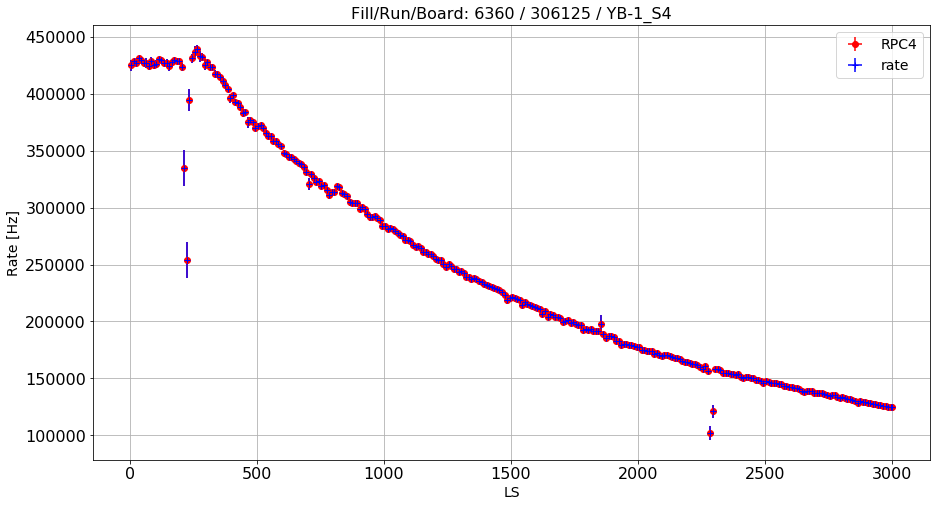

In [191]:
plot_rate_vs_ls_2(temp1, temp2, "ls", "RPC1", 0, "errRPC1", "LS", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "ls", "RPC2", 0, "errRPC2", "LS", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "ls", "RPC3", 0, "errRPC3", "LS", 
                "Rate [Hz]", title, "ro")
plot_rate_vs_ls_2(temp1, temp2, "ls", "RPC4", 0, "errRPC4", "LS", 
                "Rate [Hz]", title, "ro")

Checking some cross-sections:

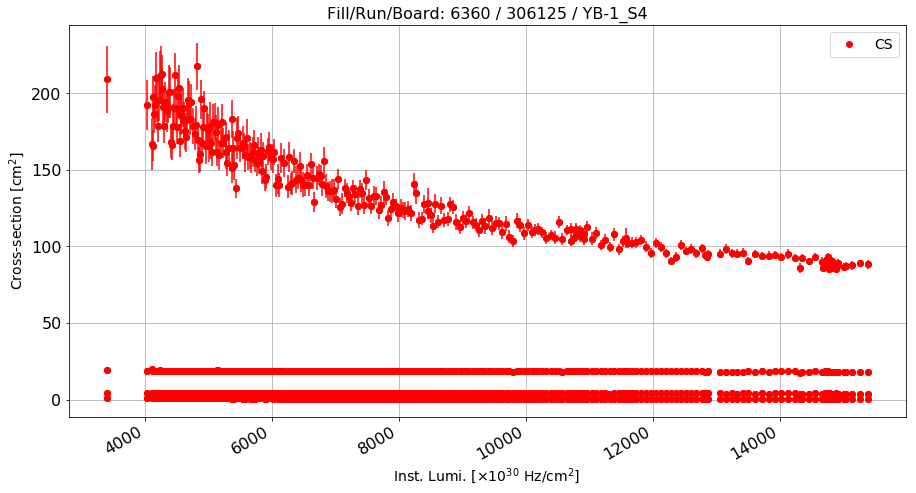

In [157]:
title = "Fill/Run/Board: "+str(int_lumi2[int_lumi2.run == 306125]["fill"].iloc[0])+\
" / "+str(boundaries["run"].iloc[3])+" / YB-1_S4"

plot_rate_vs_ls(df_rates_new_2, 306125, "lumi", "CS", "YB-1_S6", 0, "errCS",\
                r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                "Cross-section [cm$^{2}$]", title, "ro")

In [232]:
def plot_scatter_2(df, arg, wheel, norm = False, show = True):
    wheel_s = "All"
    temp = df.copy()
    if wheel != -3:
        temp = temp[(temp["wheel"] == wheel)]
        wheel_s = str(wheel)
    else:
        return 1
    
    temp = temp.groupby(['run', 'wheel', 'sector', 'system', 'station'])\
    [[arg]].mean().reset_index()
    #print temp
    
    mat = []
    for i in [4, 3, 2, 1]:
        rule = (temp.station == i)
        temp2 = temp[rule].sort_values(["sector"], ascending=True)
        vec = list(temp2[arg].values)
        mat.append(vec)      
        #print i, temp[rule][arg].values
    if norm:
        mat = mat/np.matrix(mat).sum()
        mat = [100*i for i in mat]
    #print mat

    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(["1", "2", "3", "4"])
    ax.set_yticks([4, 3, 2, 1, 0])
    ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    
    plt.xlabel("Sector")
    plt.ylabel("Station")
    title = "Wheel: "+wheel_s
    plt.title(title, loc="left")   

    im = ax.imshow(mat, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    if show:
        for i in range(0,4):
            for j in range(0,12):
                if (mat[i][j] == 0):
                    ax.text(j, i, -1,\
                    ha="center", va="center", color="r")
                else:
                    text = ax.text(j, i, round(mat[i][j], 2),\
                    ha="center", va="center", color="w")
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(mat)), np.max(np.nan_to_num(mat))])
    plt.show()

Checking the average cross-sections for the good run (not so meaningfull in some cases because of the non-linearity):

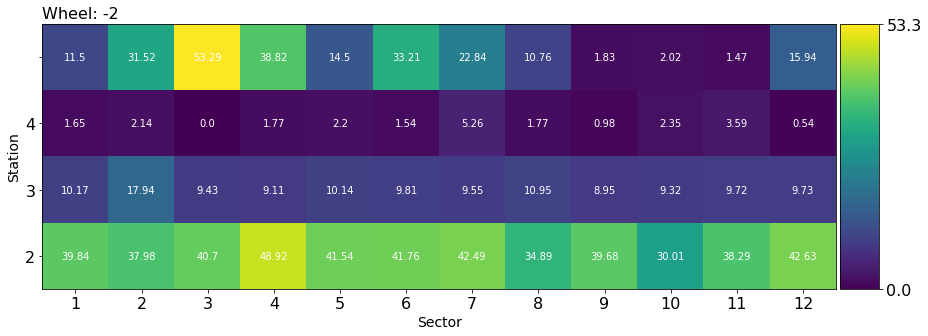

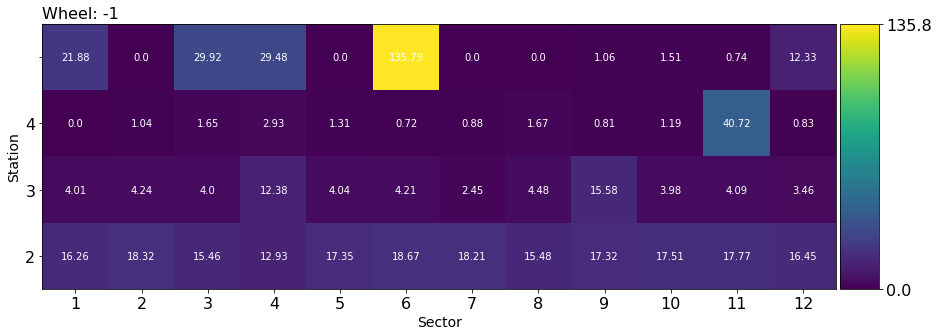

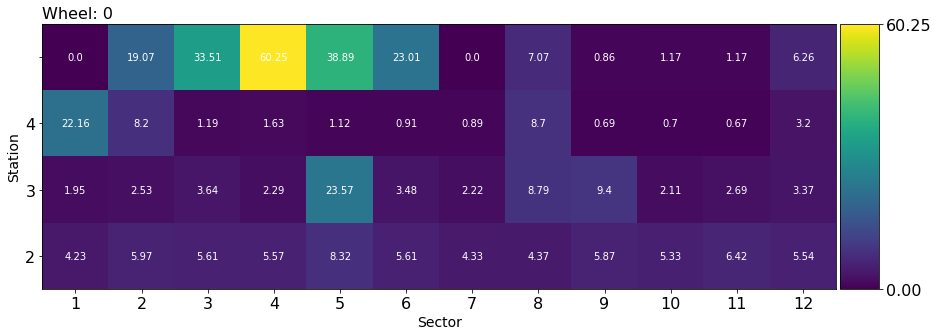

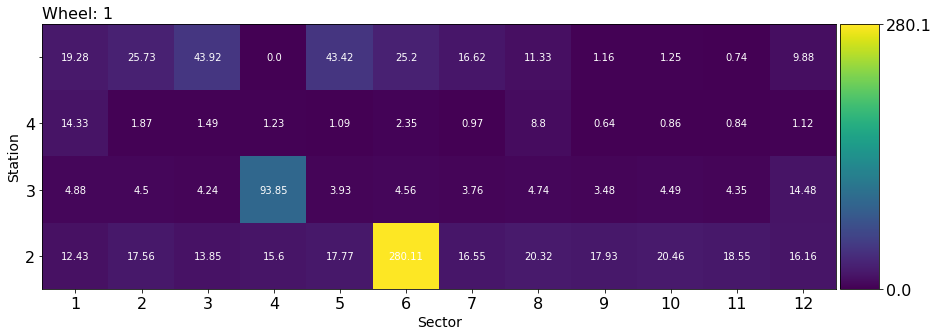

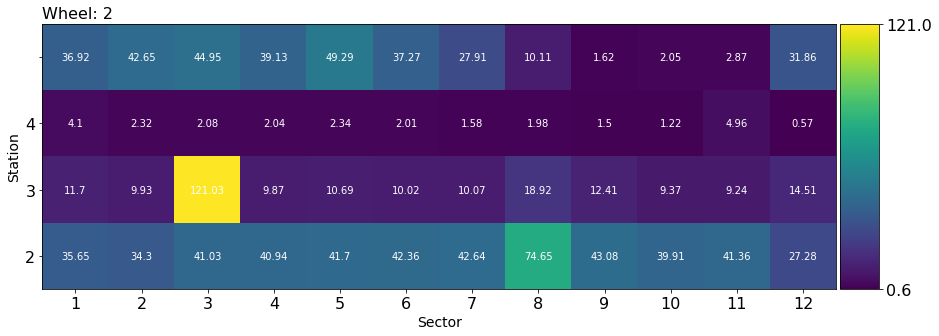

In [208]:
plot_scatter_2(df_rates_new_2[df_rates_new_2.run == 306125], "CS", -2)
plot_scatter_2(df_rates_new_2[df_rates_new_2.run == 306125], "CS", -1)
plot_scatter_2(df_rates_new_2[df_rates_new_2.run == 306125], "CS", 0)
plot_scatter_2(df_rates_new_2[df_rates_new_2.run == 306125], "CS", +1)
plot_scatter_2(df_rates_new_2[df_rates_new_2.run == 306125], "CS", +2)

Plotting the cross-sections for the good and anomalous runs on the same canvas:

In [176]:
def plot_ratio_vs_ls(df, run, x_val, y_val, z_val, x_err, y_err, title_x, title_y, title, opt, log):
    df_temp = df.copy()
    fig, ax = plt.subplots()
    fig.autofmt_xdate()
    plt.xlabel(title_x)
    plt.ylabel(title_y)
    ax.grid()
    if log:
        ax.set_yscale('log')
    df_temp["ratio"] = df_temp[y_val]/df_temp[x_val]
    df_temp["errRatio"] = (1/df_temp[x_val])*\
    np.sqrt(df_temp[y_err]**2 + df_temp["errLumi"]**2*df_temp["ratio"]**2)
    for i in range(len(run)):
        rule = ((df_temp["board"] == z_val) & (df_temp["run"] == run[i]))
        #plt.plot(df_temp[rule][x_val], df_temp[rule]["ratio"], opt[i], label=str(run[i]))
        newstr = opt[i].replace("o", "")
        plt.errorbar(df_temp[rule][x_val], df_temp[rule]["ratio"], xerr=x_err,\
        yerr=df_temp[rule]["errRatio"], fmt=opt[i], ecolor=newstr, label=str(run[i]))
    plt.legend(loc="best")
    plt.title(title)
    plt.show()

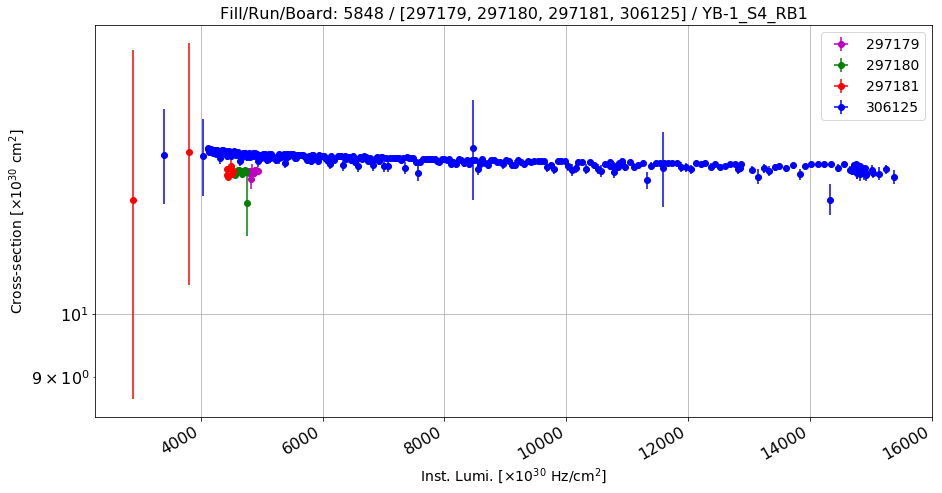

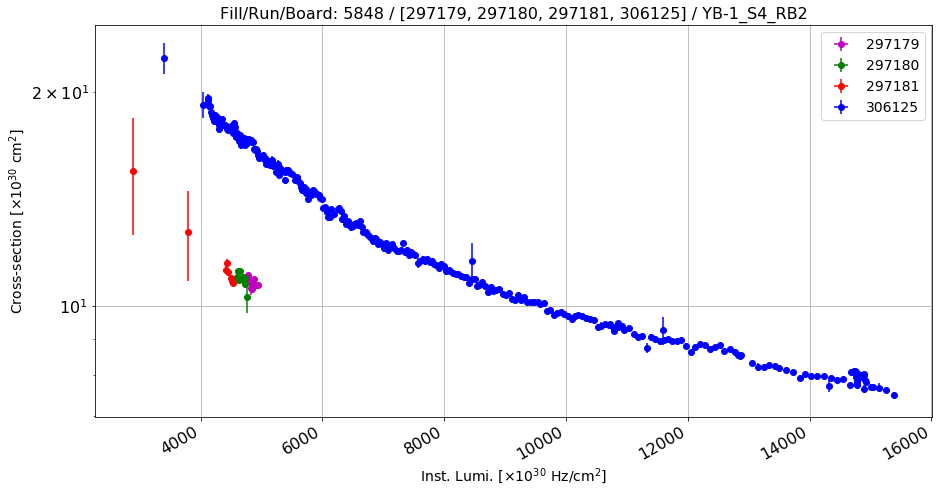

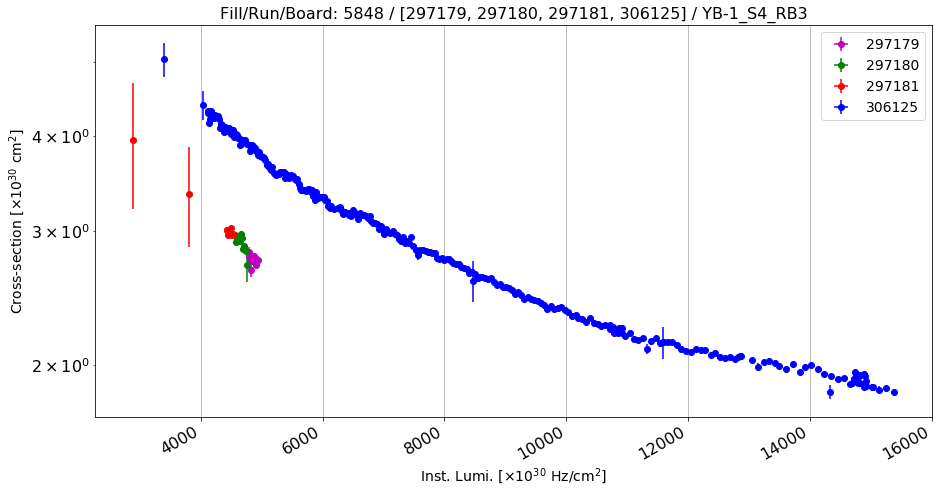

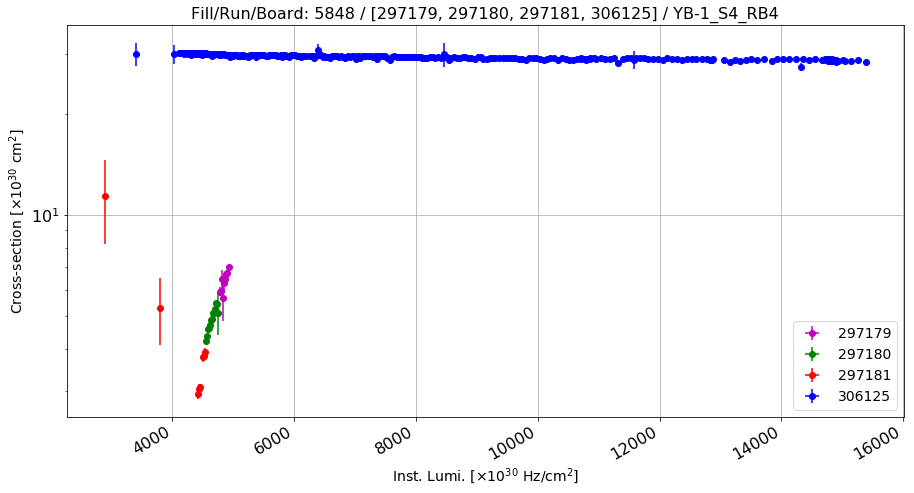

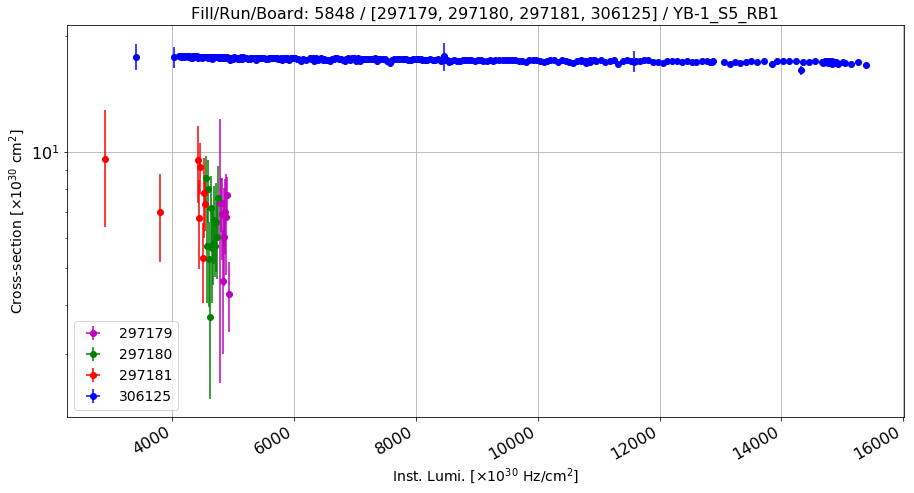

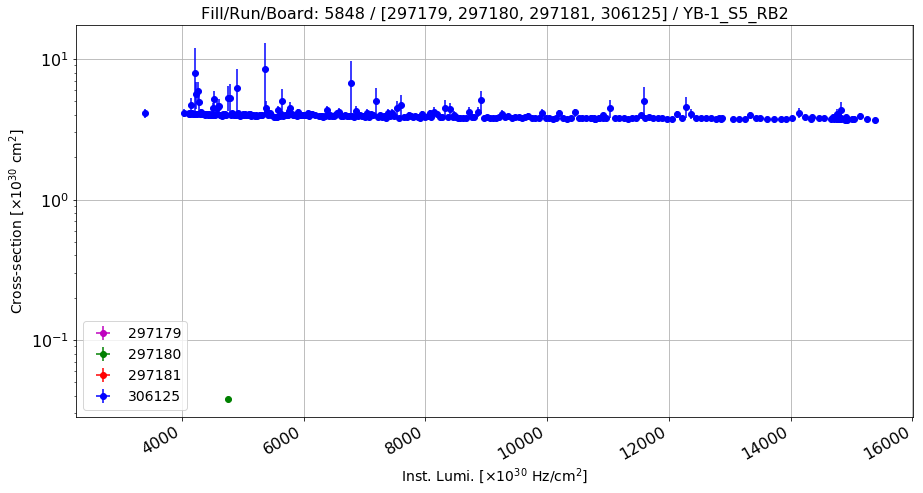

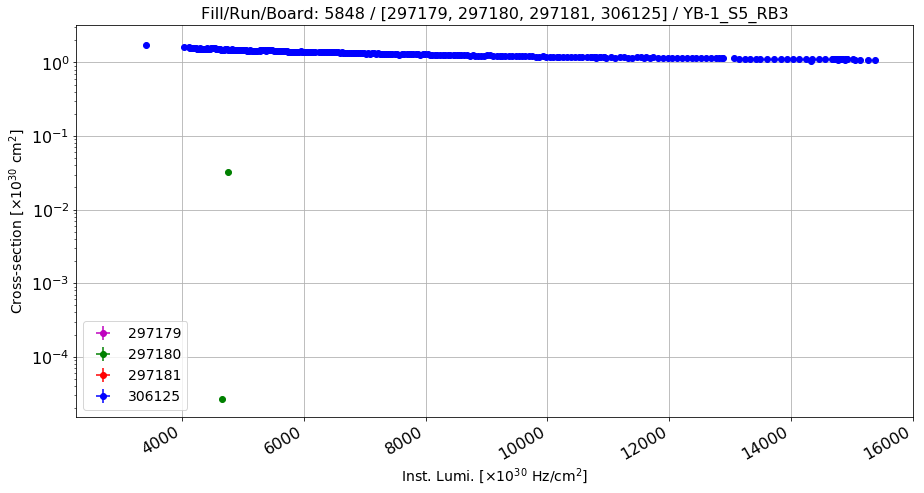

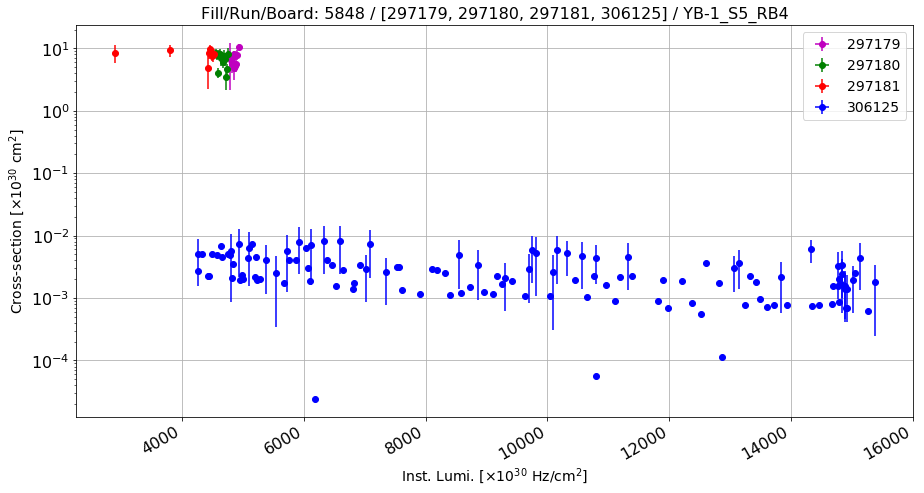

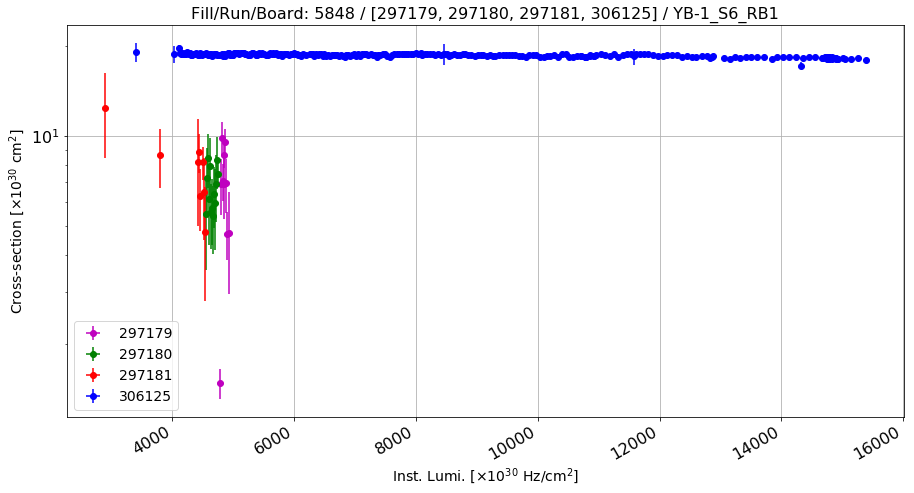

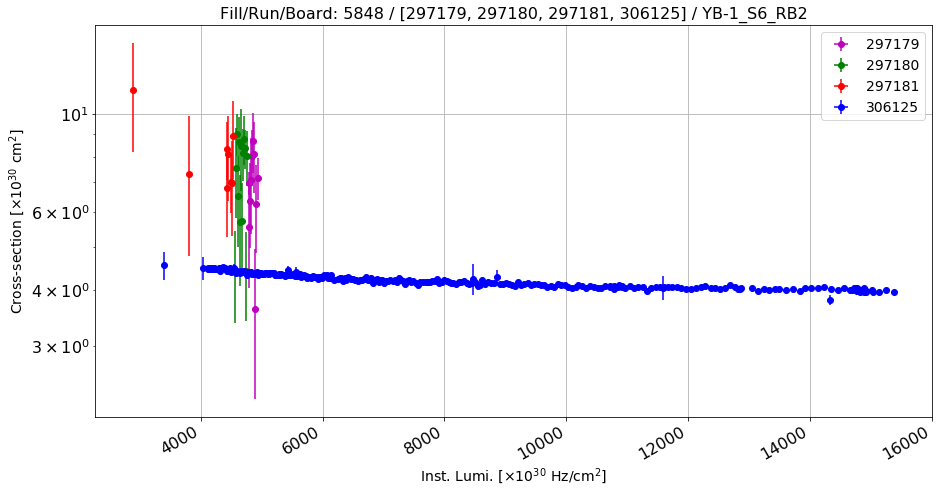

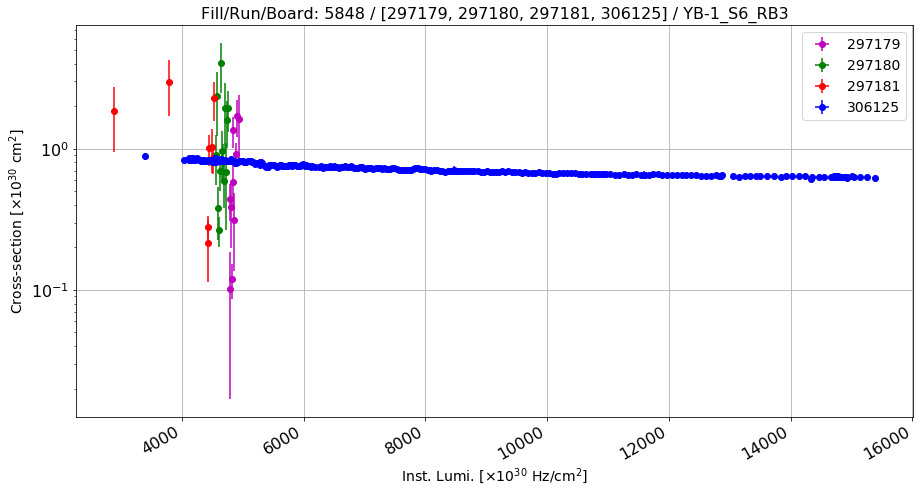

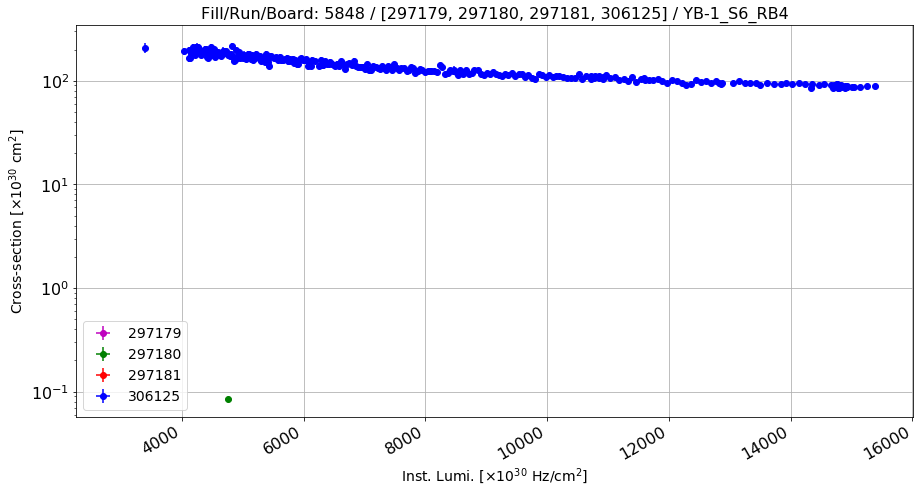

In [180]:
#for i in [-2, -1, 0, +1, +2]:
for i in [-1]:
    for j in range(4, 7):
        range_ = range(1, 5)
        for k in range_:

            if (i > 0):
                board = "YB+" + str(i) + "_S" + str(j)
            else:
                board = "YB" + str(i) + "_S" + str(j)
            station = "RPC" + str(k)
            
            error = "err"+station
            
            title = "Fill/Run/Board: "+str(int_lumi2["fill"].iloc[0])+\
                            " / "+str("[297179, 297180, 297181, 306125]")+" / " + board + "_RB" + str(k)
                
            plot_ratio_vs_ls(df_rates, [297179, 297180, 297181, 306125], "lumi", station, board, 0,\
                            error, r"Inst. Lumi. [$\times10^{30}$ Hz/cm$^2$]", 
                            r"Cross-section [$\times10^{30}$ cm$^{2}$]",\
                             title, ["mo", "go", "ro", "bo"], True)

Calculating the number of hits as the area under the curve Rate vs. LS. Each point is the average rate over 10 LS.

In [185]:
def calcHits(data):
    # 230 is 10 lumisections times 23.3 seconds, the duration of one LS
    return data*10*23.3

df_rates_new_2["hits"] = df_rates_new_2["rate"].apply(calcHits)
#print df_rates_new_2["hits"]

In [186]:
temp = df_rates_new_2.groupby(["wheel", "sector", "station", "run", "system"])[["hits"]].sum().reset_index()        

Normalizing the number of hits for each chamber to the total number of hits collected during the run:. N.B.: the numbers are percentages.

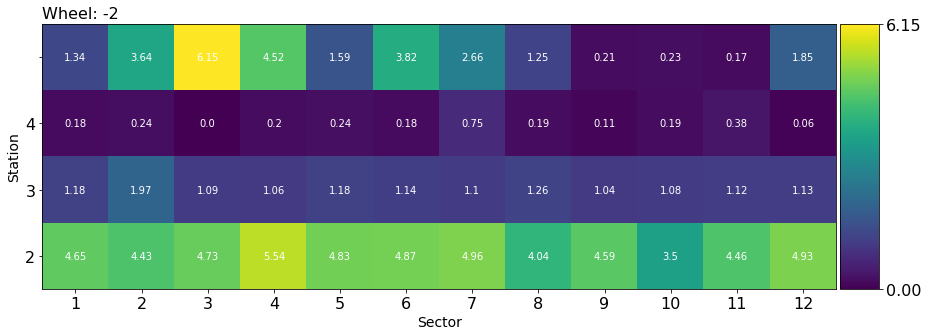

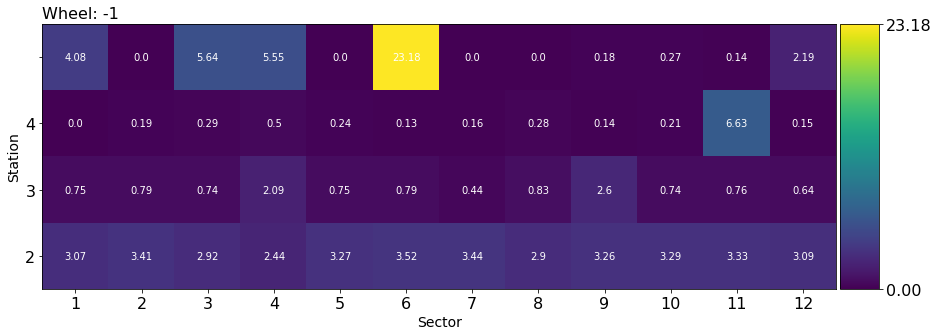

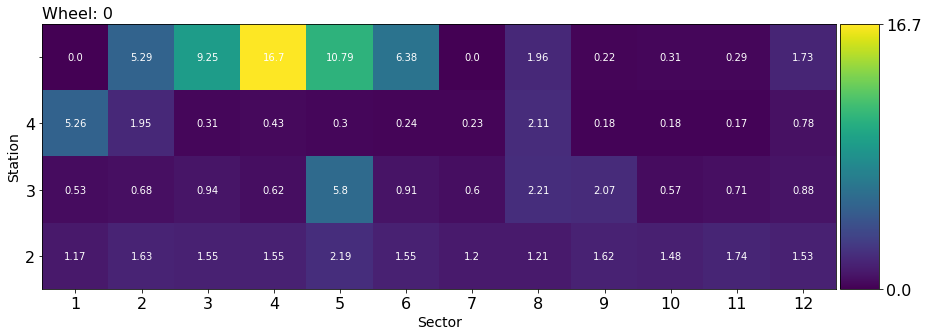

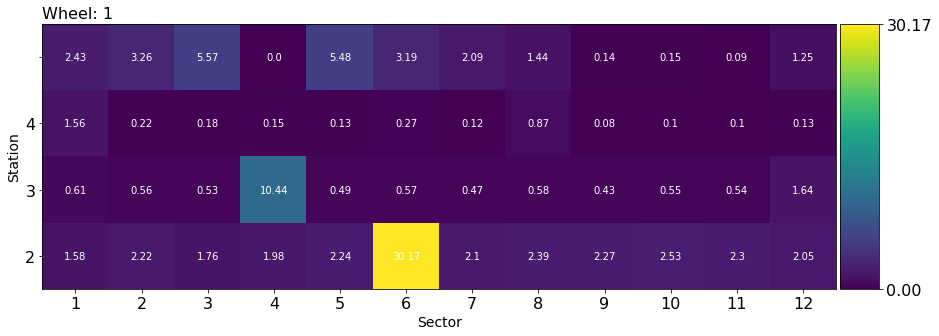

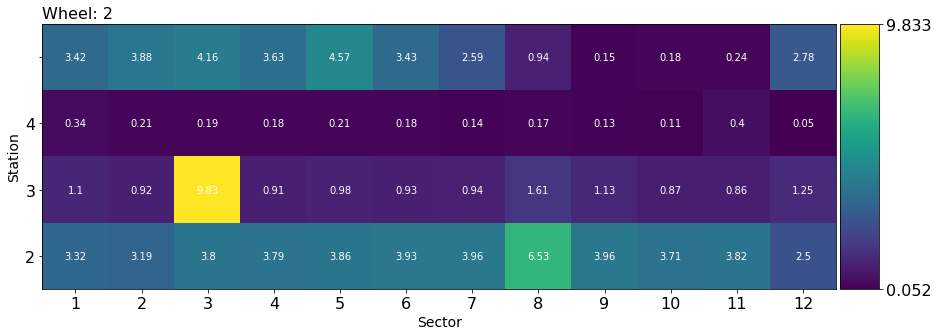

In [233]:
plot_scatter_2(temp[temp.run == 306125], "hits", -2, True)
plot_scatter_2(temp[temp.run == 306125], "hits", -1, True)
plot_scatter_2(temp[temp.run == 306125], "hits", 0, True)
plot_scatter_2(temp[temp.run == 306125], "hits", +1, True)
plot_scatter_2(temp[temp.run == 306125], "hits", +2, True)

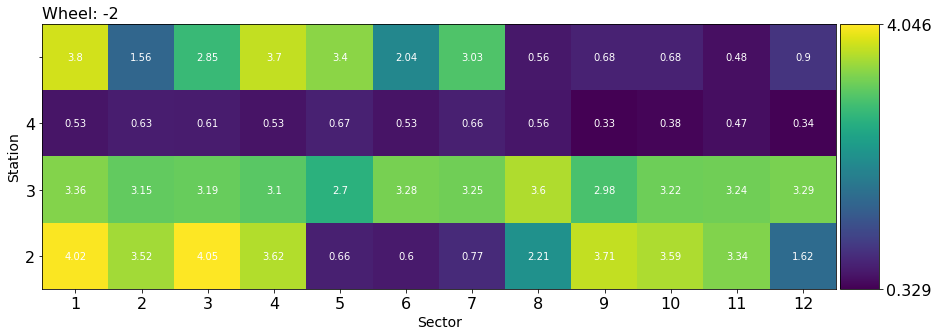

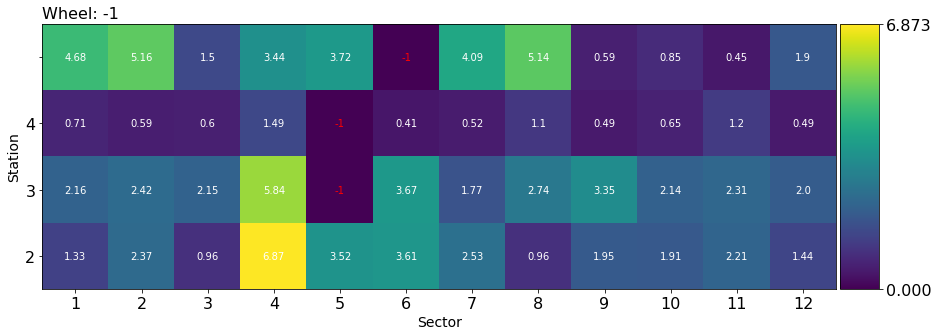

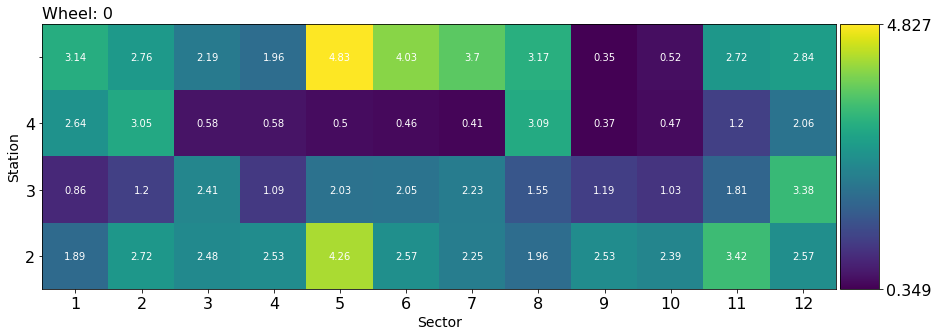

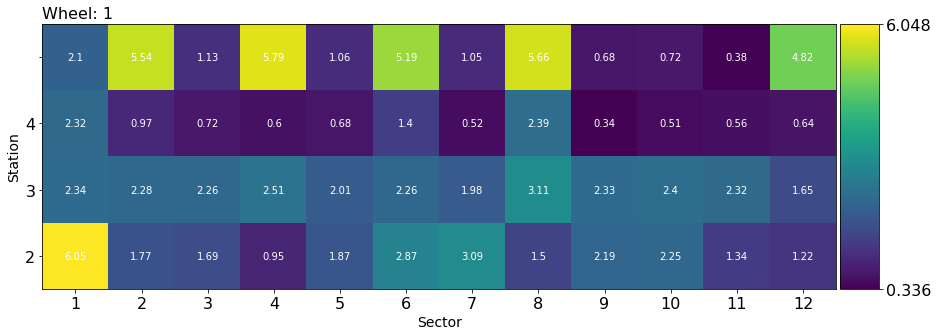

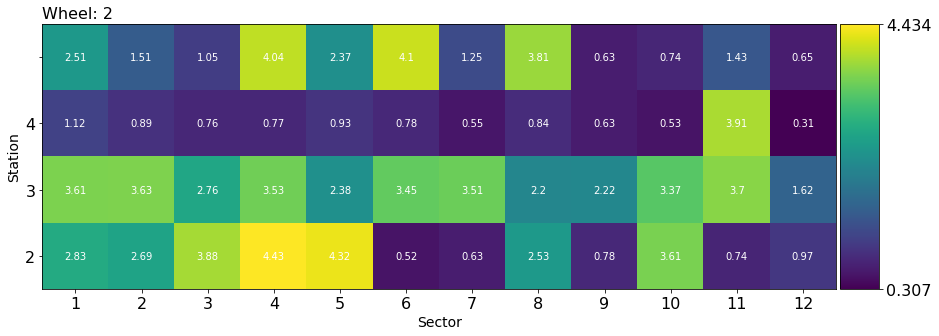

In [234]:
plot_scatter_2(temp[temp.run == 297179], "hits", -2, True)
plot_scatter_2(temp[temp.run == 297179], "hits", -1, True)
plot_scatter_2(temp[temp.run == 297179], "hits", 0, True)
plot_scatter_2(temp[temp.run == 297179], "hits", +1, True)
plot_scatter_2(temp[temp.run == 297179], "hits", +2, True)

# Model training section <a class="anchor" id="fourth-bullet"></a>

Creating train and test samples:

In [134]:
anomalies = df_rates_new_2.copy()

In [135]:
normalies = anomalies.copy()

In [136]:
print len(normalies), len(anomalies)

139750 139750


In [137]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3) 
print "Normal chimney:"
print normalies[rule]["content"].iloc[0]

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print "Anomalous chimney:"
print normalies[rule]["content"].iloc[0]

Normal chimney:
[2 -1 3 3 14972.386553571416 20.1862083622483 3265.875 9.729125589705358
 0.21812654838389672 0.0013556592604652953]
Anomalous chimney:
[2 1 4 3 14972.386553571416 20.1862083622483 2487.1964285714284
 8.244337672863274 0.16611890293322334 0.001351328555447277]


In [138]:
def assignScore(df, score):
    temp = df.copy()
    rule = (temp["wheel"] == 1) & (temp["sector"] == 4) & (temp["station"] == 3)
    indexes = temp[rule].index
    #print indexes
    for i in indexes:
        temp.loc[i, "score"] = score
    return temp

temp = assignScore(anomalies, 1)
anomalies = temp

In [139]:
#rule = (anomalies["wheel"] == 1) & (anomalies["sector"] == 4) & (anomalies["station"] == 3)
#print anomalies[rule]["score"]

Forcing the rate to the one of the symmetric chimney chamber:

In [140]:
def assignRate(df):
    rule1 = (df["wheel"] == 1) & (df["sector"] == 4) & (df["station"] == 3)# not good
    indexes1 = df[rule1].index
    #print indexes
    for i in indexes1:
        group = df.loc[i]["group"]
        run = df.loc[i]["run"]
        rule2 = (df["wheel"] == -1) & (df["sector"] == 3) & (df["station"] == 3) &\
            (df["group"] == group) & (df["run"] == run)
        indexes2 = (df[rule2].index) #it should contain one index
        #print i, index, time
        if(len(indexes2) > 0):
            j = indexes2[0]
            array = df.loc[j]["content"]
            rate = array[6] #good rate from the symmetric sector
            err = array[7] #uncertainty on the good rate from the symmetric sector
            CS = array[8]
            errCS = array[9]
            content_orig = df.loc[i]["content"]
            content = list(content_orig)
            content[6] = rate
            content[7] = err
            content[8] = CS
            content[9] = errCS
            df.at[i, "content"] = content
            #print i, j, time, rate, content_orig, content
        else:
            content_orig = df.loc[i]["content"]
            content = list(content_orig)
            content[6] = -1
            content[7] = -1
            content[8] = -1
            content[9] = -1
            df.at[i, "content"] = content
            #print i, j, time, rate, content_orig, content

assignRate(normalies)

Check that the change affects only normalies:

In [141]:
rule = (normalies["wheel"] == -1) & (normalies["sector"] == 3) & (normalies["station"] == 3)
print "Normal chimney:"
print normalies[rule]["content"].iloc[0]

rule = (normalies["wheel"] == 1) & (normalies["sector"] == 4) & (normalies["station"] == 3)
print "Anomalous chimney:"
print normalies[rule]["content"].iloc[0]

Normal chimney:
[2 -1 3 3 14972.386553571416 20.1862083622483 3265.875 9.729125589705358
 0.21812654838389672 0.0013556592604652953]
Anomalous chimney:
[2, 1, 4, 3, 14972.386553571416, 20.1862083622483, 3265.875, 9.729125589705358, 0.21812654838389672, 0.0013556592604652953]


In [142]:
rule = (anomalies["wheel"] == -1) & (anomalies["sector"] == 3) & (anomalies["station"] == 3)
print "Normal chimney:"
print anomalies[rule]["content"].iloc[0]

rule = (anomalies["wheel"] == 1) & (anomalies["sector"] == 4) & (anomalies["station"] == 3)
print "Anomalous chimney:"
print anomalies[rule]["content"].iloc[0]

Normal chimney:
[2 -1 3 3 14972.386553571416 20.1862083622483 3265.875 9.729125589705358
 0.21812654838389672 0.0013556592604652953]
Anomalous chimney:
[2 1 4 3 14972.386553571416 20.1862083622483 2487.1964285714284
 8.244337672863274 0.16611890293322334 0.001351328555447277]


In [144]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer
def scale_data(data, scaler_type = 2):
    
    types = ["RobustScaler", "MaxAbsScaler", "QuantileTransformerUniform",\
             "QuantileTransformerNormal", "Normalizer", "MinMaxScaler"]
    #print "Scaling data using:", types[scaler_type-1]
    
    # Need to reshape since scaler works per column
    data = data.reshape(-1, 1)
    if (scaler_type == 1):
        scaler = RobustScaler(quantile_range=(25, 75)).fit(data)
    if (scaler_type == 2):
        scaler = MaxAbsScaler().fit(data)
    if (scaler_type == 3):
        scaler = QuantileTransformer(output_distribution='uniform').fit(data)
    if (scaler_type == 4):
        scaler = QuantileTransformer(output_distribution='normal').fit(data)
    if (scaler_type == 5):
        scaler = Normalizer().fit(data)
    if (scaler_type == 6):
        scaler = MinMaxScaler().fit(data)
    return scaler.transform(data).reshape(1, -1)

In [145]:
anomalies["content"] = anomalies["content"].apply(np.array)
anomalies["content_scaled"] = anomalies["content"].apply(scale_data)

normalies["content"] = normalies["content"].apply(np.array)
normalies["content_scaled"] = normalies["content"].apply(scale_data)

In [146]:
#print anomalies["content_scaled"]
#print normalies["content_scaled"]

In [147]:
# Set a random seed to reproduce the results
rng = np.random.RandomState(0)
anomalies = anomalies[(anomalies.score == 1) & (anomalies.run != 305814)]
normalies = normalies[(normalies.score == -1) & (normalies.run != 305814)]
print("%s faults and %s good samples. In total: %s." %
      (len(anomalies), len(normalies), len(anomalies) + len(normalies)))

anomalies_train, anomalies_test = train_test_split(anomalies, test_size = 0.2, random_state=rng)
normalies_train, normalies_test = train_test_split(normalies, test_size = 0.2, random_state=rng)

neural_anomalies_train, neural_anomalies_val = train_test_split(anomalies_train,\
                                                                test_size = 0.2, random_state=rng)
neural_normalies_train, neural_normalies_val = train_test_split(normalies_train,\
                                                                test_size = 0.2, random_state=rng)

layers_train = pd.concat([anomalies_train, normalies_train])
layers_test = pd.concat([anomalies_test, normalies_test])

neural_train = pd.concat([neural_anomalies_train, neural_normalies_train])
neural_val = pd.concat([neural_anomalies_val, neural_normalies_val])

375 faults and 93750 good samples. In total: 94125.


In [148]:
print("Number of anomalies in the train set: %s" % len(anomalies_train))
print("Number of normal in the train set: %s" % len(normalies_train))
print("Number of anomalies in the test set: %s" % len(anomalies_test))
print("Number of normal in the test set: %s" % len(normalies_test))

Number of anomalies in the train set: 300
Number of normal in the train set: 75000
Number of anomalies in the test set: 75
Number of normal in the test set: 18750


In [149]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
K.set_session(sess)

In [150]:
def score_to_array(score):
    if score == -1:
        return np.asarray([1, 0]) #Normaly
    return np.asarray([0, 1]) #Anomaly

def nn_generate_input():  
    return (np.array(np.concatenate(neural_train.content_scaled.values)).reshape(-1, 10),
            np.concatenate(neural_train["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(neural_val.content_scaled.values)).reshape(-1, 10),
            np.concatenate(neural_val["score"].apply(score_to_array).values).reshape(-1, 2),
            np.array(np.concatenate(layers_test.content_scaled.values)).reshape(-1, 10))

(train_x, train_y, val_x, val_y, test_x) = nn_generate_input()

In [151]:
def cae_generate_input():
    return np.array(np.concatenate(normalies.content_scaled.values)).reshape(-1, 10)

train_cae = cae_generate_input()

In [152]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight("balanced",
                                       np.unique(np.argmax(train_y, axis=1)),
                                       np.argmax(train_y, axis=1))
cw = {0: cw[0], 1: cw[1]}
print cw

{0: 0.502, 1: 125.5}


Defining NN structure:

In [153]:
dim = 10
def neural_network_1():
    model = Sequential()
    model.add(Reshape((dim, 1), input_shape=(dim,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def neural_network_2():
    model = Sequential()
    model.add(Reshape((dim, 1), input_shape=(dim,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann2"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def neural_network_3():
    model = Sequential()
    model.add(Reshape((dim, 1), input_shape=(dim,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann2"))
    model.add(Dense(32, activation='relu', name="dense_ann3"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def neural_network_4():
    model = Sequential()
    model.add(Reshape((dim, 1), input_shape=(dim,), name='input_ann'))
    model.add(Flatten(name="flatten_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann"))
    model.add(Dense(32, activation='relu', name="dense_ann2"))
    model.add(Dense(32, activation='relu', name="dense_ann3"))
    model.add(Dense(32, activation='relu', name="dense_ann4"))
    model.add(Dense(2, activation='softmax', name='output_ann'))
    return model

def autoencoder():
    from keras.layers import Input, Dense
    from keras.models import Model
    input_ = Input(shape=(10,))
    encoded = Dense(10, activation='relu')(input_)
    encoded = Dense(9, activation='relu')(encoded)
    encoded = Dense(8, activation='relu')(encoded)
    encoded = Dense(7, activation='relu')(encoded)
    encoded = Dense(6, activation='relu')(encoded)
    
    decoded = Dense(6, activation='relu')(encoded)
    decoded = Dense(7, activation='relu')(decoded)
    decoded = Dense(8, activation='relu')(decoded)
    decoded = Dense(9, activation='relu')(decoded)
    decoded = Dense(10, activation='sigmoid')(decoded)

    autoencoder = Model(input_, decoded)
    return autoencoder

In [154]:
ann_1 = neural_network_1()
ann_2 = neural_network_2()
ann_3 = neural_network_3()
ann_4 = neural_network_4()
#print("Neural Network Architecture:")
#ann_1.summary()
#ann_2.summary()
#ann_3.summary()
#ann_4.summary()

Training the NN:

In [155]:
# This may take some time...

def train_nn(model, x, y, batch_size, loss, name, validation_data=None, 
             validation_split=0.0, class_weight=None):

    model.compile(loss=loss, optimizer='Nadam')

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")
    
    checkpoint_callback = ModelCheckpoint(("./model_keras/%s.h5" % name),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    return model.fit(x, y,
                     batch_size=batch_size,
                     epochs=8192,
                     verbose=False,
                     class_weight=class_weight,
                     shuffle=True,
                     validation_split=validation_split,
                     validation_data=validation_data,
                     callbacks=[early_stopper, checkpoint_callback])

In [156]:
history_ann_1 = train_nn(ann_1,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann_1",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 00350: early stopping


In [157]:
history_ann_2 = train_nn(ann_2,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann_2",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 07529: early stopping


In [158]:
history_ann_3 = train_nn(ann_3,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann_3",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 02991: early stopping


In [159]:
history_ann_4 = train_nn(ann_4,
                       train_x,
                       train_y,
                       len(train_x),
                       keras.losses.categorical_crossentropy,
                       "ann_4",
                       validation_data=(val_x, val_y),
                       class_weight=cw)

Epoch 01485: early stopping


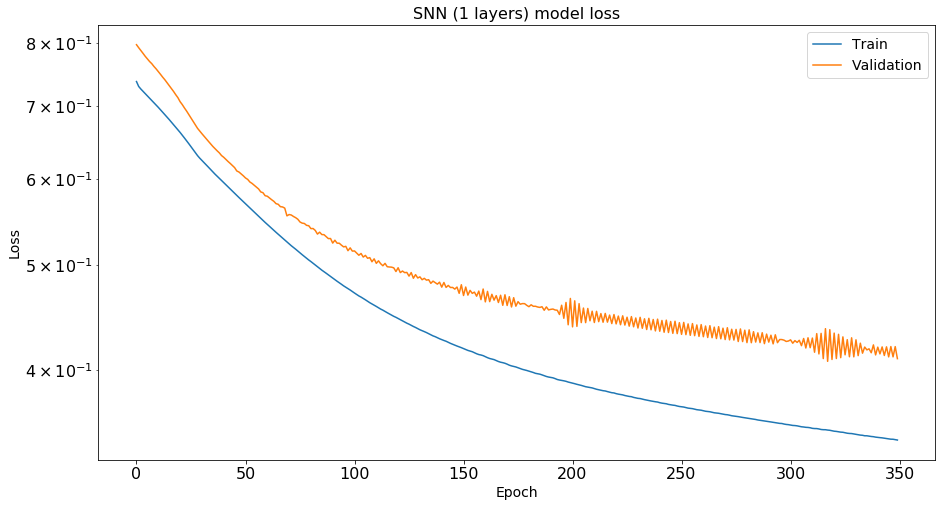

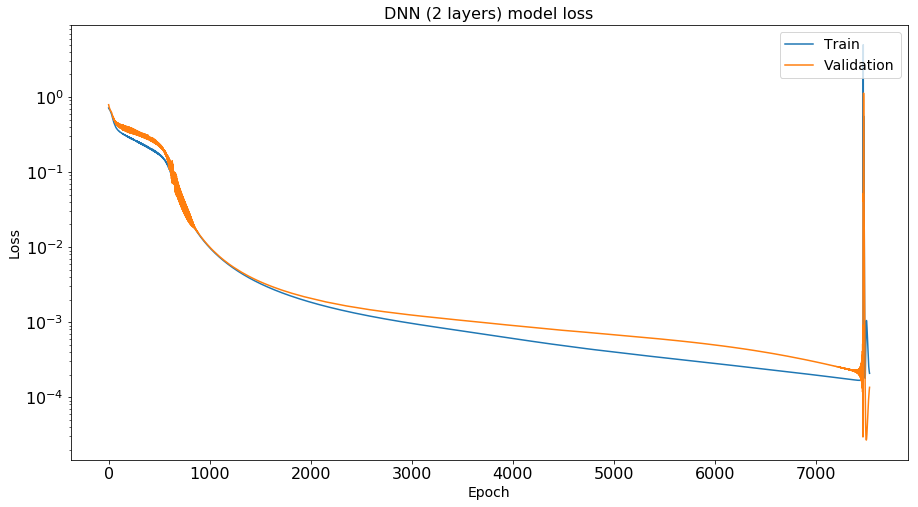

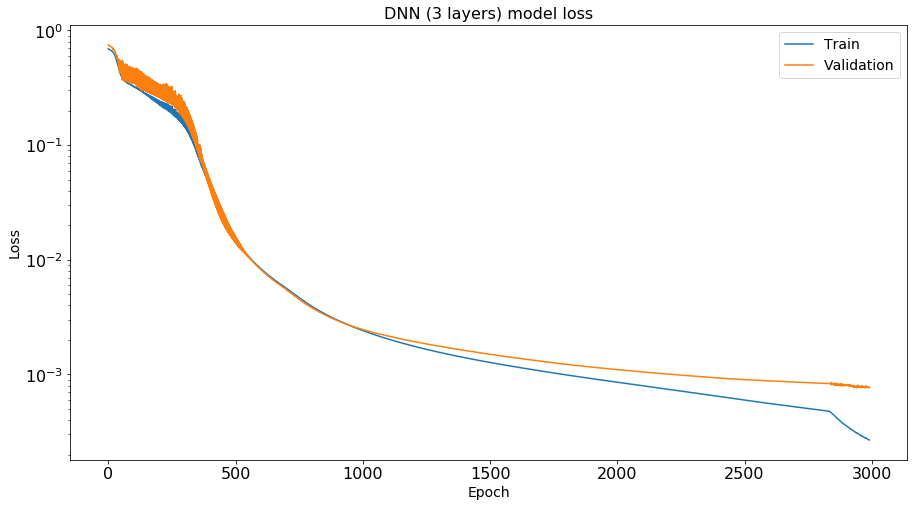

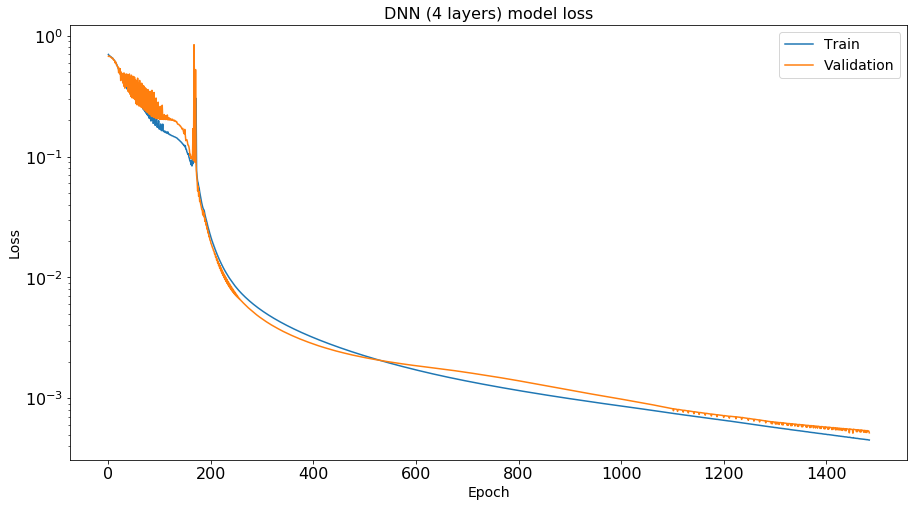

In [160]:
def plot_training_loss(data, title):
    """Plots the training and validation loss"""
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.plot(data["loss"])
    plt.plot(data["val_loss"])
    plt.legend(["Train", "Validation"], loc="upper right")
    plt.yscale("log")
    plt.show();

plot_training_loss(history_ann_1.history, "SNN (1 layers) model loss")
plot_training_loss(history_ann_2.history, "DNN (2 layers) model loss")
plot_training_loss(history_ann_3.history, "DNN (3 layers) model loss")
plot_training_loss(history_ann_4.history, "DNN (4 layers) model loss")

Making an inference using the model and the test sample:

In [161]:
ann_model_1 = load_model("./model_keras/ann_1.h5")
ann_model_2 = load_model("./model_keras/ann_2.h5")
ann_model_3 = load_model("./model_keras/ann_3.h5")
ann_model_4 = load_model("./model_keras/ann_4.h5")

In [162]:
layers_test["ann_score_1"] = ann_model_1.predict(np.array(test_x))[:, 1]
layers_test["ann_score_2"] = ann_model_2.predict(np.array(test_x))[:, 1]
layers_test["ann_score_3"] = ann_model_3.predict(np.array(test_x))[:, 1]
layers_test["ann_score_4"] = ann_model_4.predict(np.array(test_x))[:, 1]

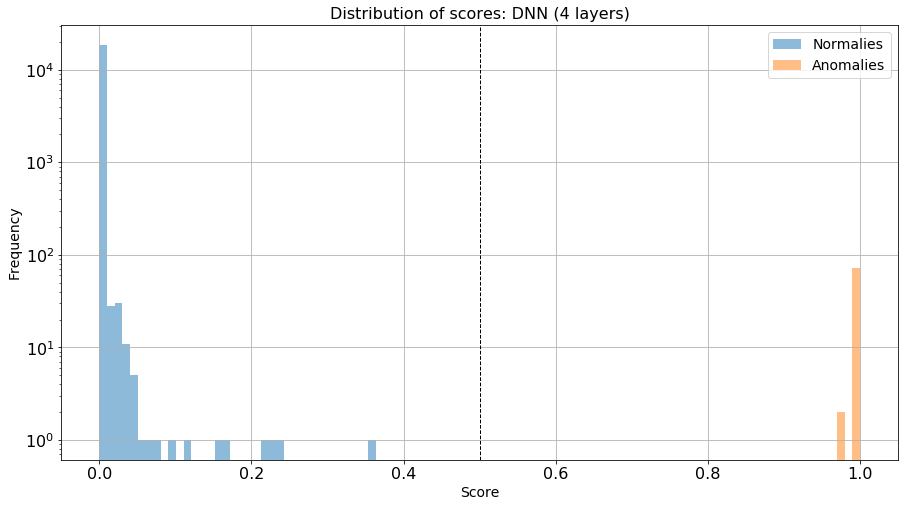

In [163]:
# Distribution of scores:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, 1, 100)
plt.hist(layers_test[layers_test["score"] < 0]["ann_score_4"], bins=bins, alpha=0.5, label="Normalies")
plt.hist(layers_test[layers_test["score"] > 0]["ann_score_4"], bins=bins, alpha=0.5, label="Anomalies")
plt.title("Distribution of scores: DNN (4 layers)")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.axvline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.show()

In [164]:
def get_roc_curve(test_df, models, working_point=None):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
    ax.grid()

    for legend_label, model_score in models:
        false_positive_rate, true_positive_rate, _ = roc_curve(test_df["score"],
                                                               test_df[model_score])
        #plt.xlim(0, 0.2)
        plt.plot(false_positive_rate, true_positive_rate, linewidth=2,
                 label=('%s, AUC: %s' % (legend_label,
                                         round(auc(false_positive_rate, true_positive_rate), 4))))
    if working_point:
        plt.plot(1-working_point[0],
                 working_point[1],
                 'o',
                 label="DNN working point")
    plt.title("ROC")
    plt.legend(loc='best')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.show();

In [172]:
cae = autoencoder()
#print("Autoencoder Architecture:")
#cae.summary()

Epoch 00133: early stopping


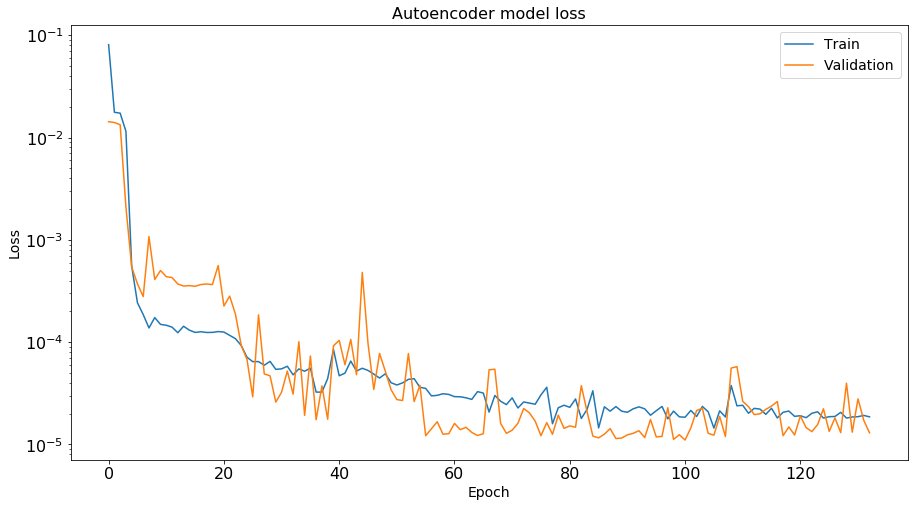

In [173]:
history_cae = train_nn(cae,
                       train_cae,
                       train_cae,
                       512,
                       keras.losses.mse,
                       "cae",
                       validation_split=0.2)
plot_training_loss(history_cae.history, "Autoencoder model loss")

In [174]:
cae_model = load_model("./model_keras/cae.h5")
layers_test["cae_score"] = np.sum(abs(test_x - cae_model.predict(np.array(test_x))), axis=1)

In [175]:
def benchmark(y_true, y_score, treshold):
    y_pred = 2*(y_score > treshold)-1
    y_true = 2*(y_true > treshold)-1
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = round(float(tp)/(tp+fn), 4)
    specificity = round(float(tn)/(tn+fp), 4)

    print("Model accuracy: %s" % round(accuracy_score(y_true, y_pred), 4))
    print("Model sensitivity: %s" % sensitivity)
    print("Model specificity: %s" % specificity)

    return specificity, sensitivity
    
print "DNN:"
specificity_ann, sensitivity_ann = benchmark(layers_test["score"], layers_test["ann_score_4"], 0.5)
print "AE:"
specificity_cae, sensitivity_cae = benchmark(layers_test["score"], layers_test["cae_score"], 0.035)

DNN:
Model accuracy: 1.0
Model sensitivity: 1.0
Model specificity: 1.0
AE:
Model accuracy: 0.9648
Model sensitivity: 0.9867
Model specificity: 0.9647


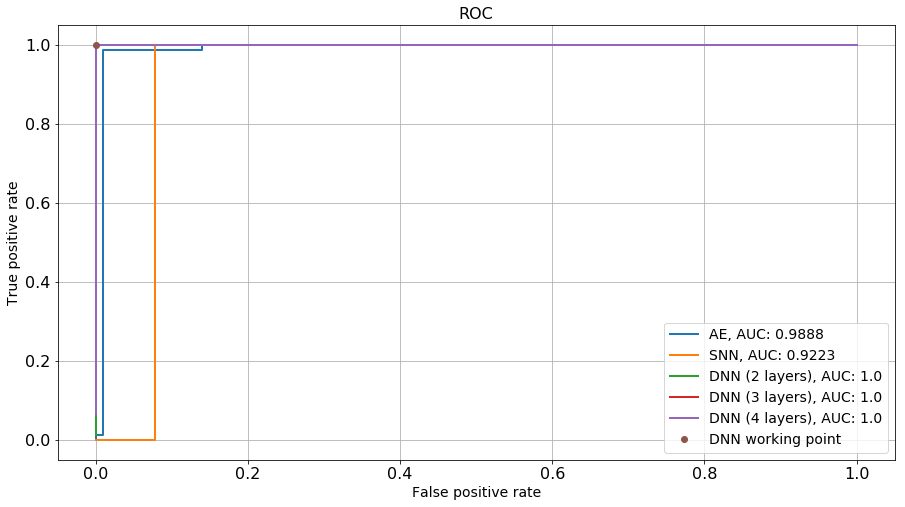

In [176]:
get_roc_curve(layers_test, 
              [
               ("AE", "cae_score"),
               ("SNN", "ann_score_1"),
               ("DNN (2 layers)", "ann_score_2"),
               ("DNN (3 layers)", "ann_score_3"),
               ("DNN (4 layers)", "ann_score_4"),
               ], (specificity_ann, sensitivity_ann))

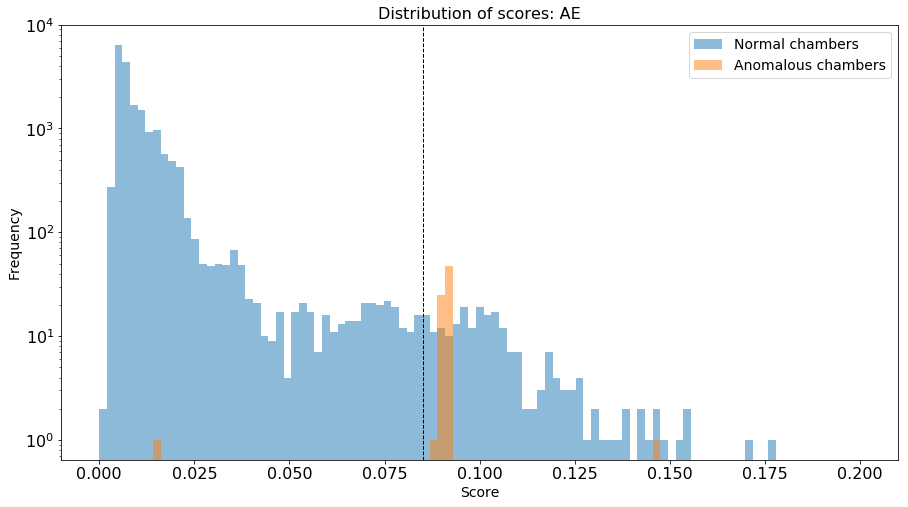

In [196]:
fig, ax = plt.subplots()
ax.set_yscale('log')
#ax.grid()
bins = np.linspace(0, 0.2, 100)
plt.hist(layers_test[layers_test["score"] < 0]["cae_score"], bins=bins,\
         alpha=0.5, label="Normal chambers")
plt.hist(layers_test[layers_test["score"] > 0]["cae_score"], bins=bins,\
         alpha=0.5, label="Anomalous chambers")
plt.title("Distribution of scores: AE")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.axvline(0.085, color='k', linestyle='dashed', linewidth=1)
plt.show()

Setting thresholds:

In [197]:
th_dnn = 0.5
th_ae = 0.085

In [180]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


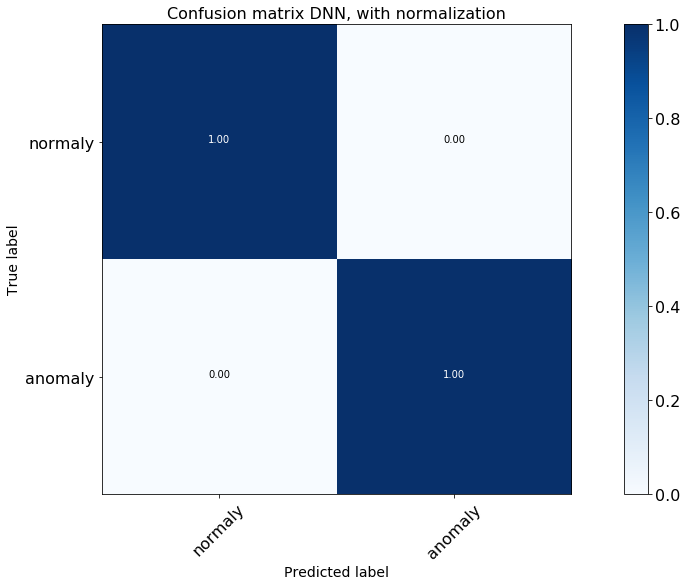

In [181]:
threshold = th_dnn
y_pred = 2*(layers_test["ann_score_4"] > threshold)-1
layers_test["score"] = 2*(layers_test["score"] > threshold)-1

cnf_matrix = confusion_matrix(layers_test["score"], y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix DNN, with normalization')

Normalized confusion matrix
[[ 0.98842667  0.01157333]
 [ 0.01333333  0.98666667]]


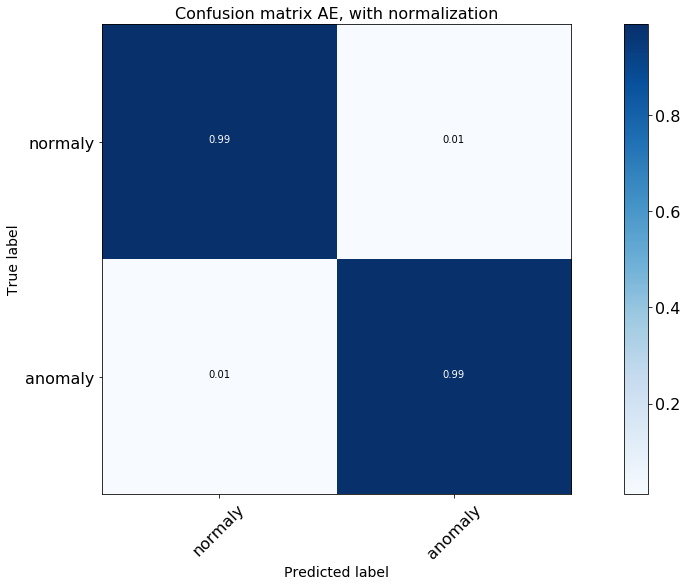

In [198]:
threshold = th_ae
y_pred = 2*(layers_test["cae_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix AE, with normalization')

In [183]:
print "Number of FPs for the DNN:", len(layers_test[(layers_test["score"] == -1) &\
                                                    (layers_test["ann_score_4"] > th_dnn)])

Number of FPs for the DNN: 0


In [199]:
print "Number of FPs for the AE:", len(layers_test[(layers_test["score"] == -1) &\
                                                   (layers_test["cae_score"] > th_ae)])

Number of FPs for the AE: 217


In [200]:
layers_test["name"] = ("W" + layers_test["wheel"].astype(str) + "_S" + layers_test["sector"].astype(str) +\
       "_St" + layers_test["station"].astype(str))

Where are the FPs located?

In [201]:
def count_fp(df, dis_nn, th, filt):
    df_temp = df[(layers_test["score"] == -1) & (layers_test[dis_nn] > th)].copy()
    df_temp = df_temp.groupby(['run', 'wheel', 'sector', 'station', 'name'])\
    .size().reset_index(name='counts')
    if filt:
        df_temp = df_temp[df_temp["counts"] > 1]
    #print df_temp
    return len(df_temp), df_temp

num_fp_ann, fp_ann = count_fp(layers_test, "ann_score_4", th_dnn, False)
num_fp_cae, fp_cae = count_fp(layers_test, "cae_score", th_ae, True)

print "Number of chambers with false positives DNN:", num_fp_ann
print "Number of chambers with false positives AE:", num_fp_cae
fp_cae.set_index("name",drop=True,inplace=True)
fp_ann.set_index("name",drop=True,inplace=True)

Number of chambers with false positives DNN: 0
Number of chambers with false positives AE: 41


In [189]:
#fp_ann["counts"].plot(kind='bar', title ="False positives DNN", legend=True, fontsize=12)

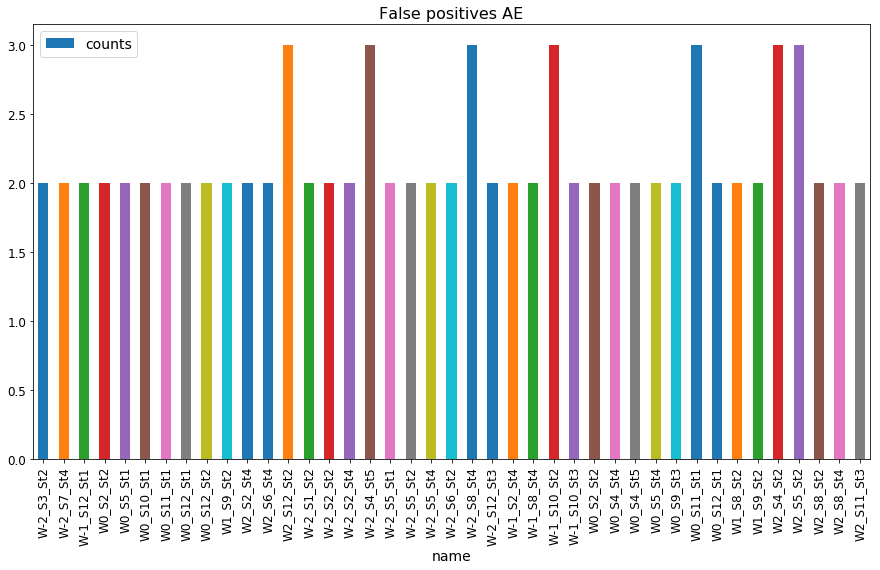

In [202]:
fp_cae["counts"].plot(kind='bar', title ="False positives AE", legend=True, fontsize=12)

In [190]:
def get_matrix(df):
    x = np.zeros((5,12),dtype=int)
    for i in range(len(df)):
        a = int(5-df["station"].iloc[i])
        b = int(df["sector"].iloc[i]-1)
        x[a,b] = x[a,b] + 1
    return x

def deduceLS(data):
    return data*10+5
layers_test["averageLS"] = layers_test["group"].apply(deduceLS)

[[0 0 0 1 0 0 0 0 0 0 0 0]
 [2 2 0 0 1 2 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 3 2 1 2 0 0 1 0 0 2]
 [1 1 2 2 1 2 1 1 0 1 1 1]]
36


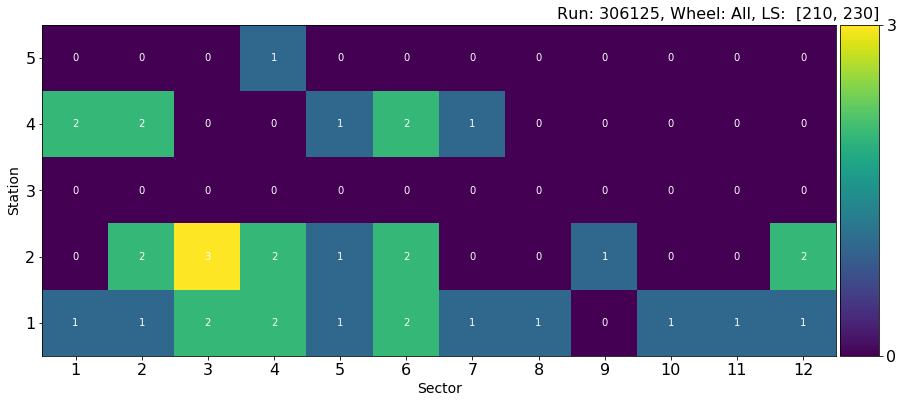

[[0 0 0 3 0 0 0 0 0 0 0 0]
 [1 3 1 0 2 2 2 3 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 1 1 2]
 [2 3 3 2 2 3 1 2 1 0 1 1]
 [0 1 0 0 2 0 1 0 0 0 0 1]]
49


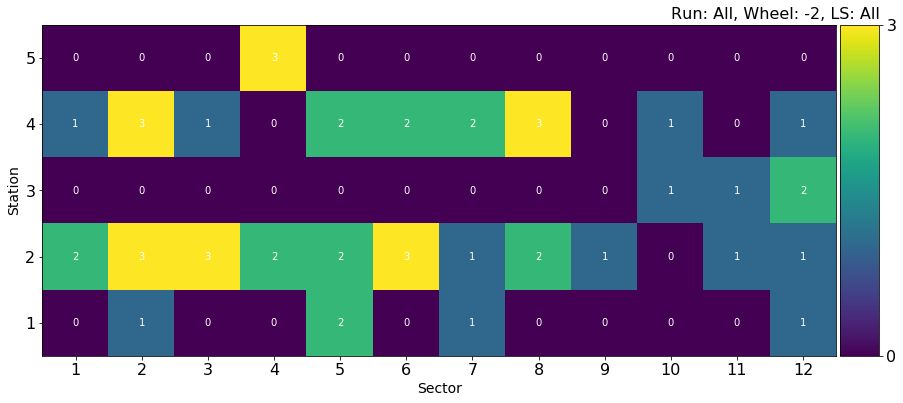

[[0 0 0 2 0 0 0 0 0 0 0 0]
 [0 2 1 0 0 1 1 2 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 2 0 0]
 [1 1 2 1 1 1 0 0 0 3 2 1]
 [1 1 1 1 0 0 0 1 0 0 1 2]]
34


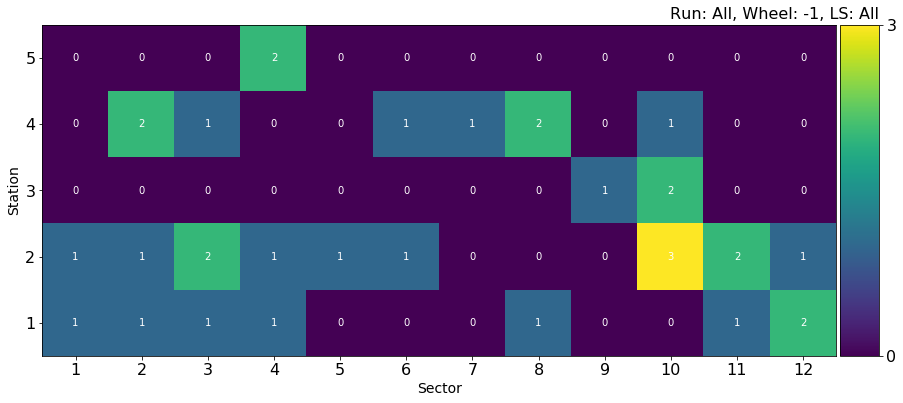

[[0 0 0 3 0 0 0 0 0 0 0 0]
 [0 1 0 2 3 0 1 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 2 0 0 1]
 [1 4 1 0 1 1 0 0 1 1 2 3]
 [0 2 1 0 3 2 1 2 0 2 5 4]]
52


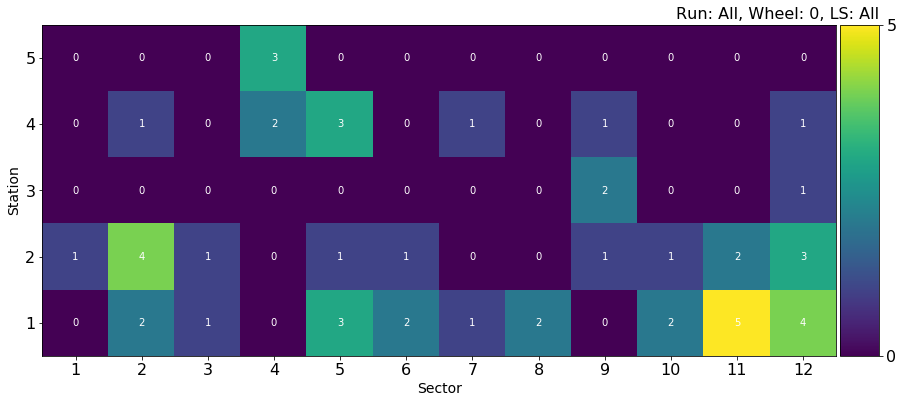

[[0 0 0 2 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 1 1 1 1 1 0 1]
 [0 1 2 0 1 2 1 3 4 1 1 0]
 [1 0 0 2 0 2 1 1 1 0 1 2]]
39


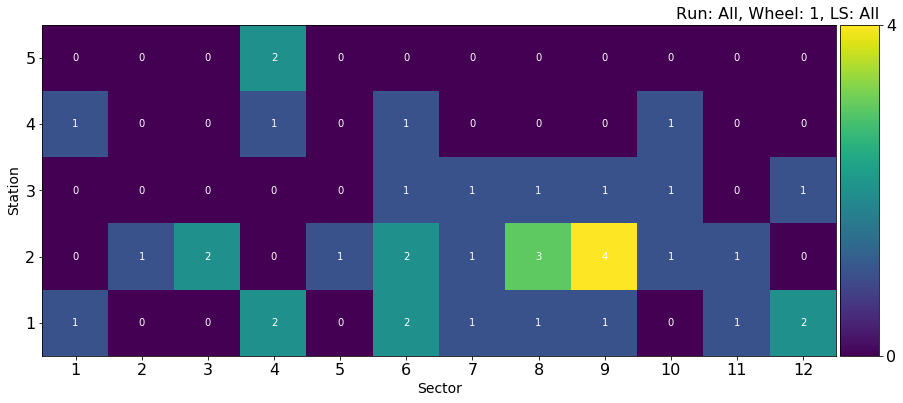

[[0 0 0 1 0 0 0 0 0 0 0 0]
 [2 2 1 0 2 3 1 2 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 2 0]
 [1 1 0 4 3 1 1 2 1 2 1 3]
 [1 1 0 0 1 0 0 1 1 0 0 0]]
43


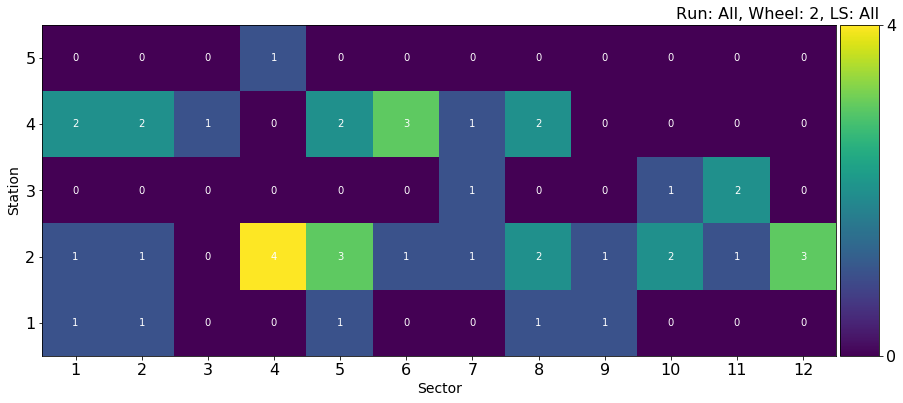

In [203]:
def plot_scatter(df, run, wheel, ls_min, ls_max):
    run_s = "All"
    wheel_s = "All"
    ls_s = "All"
    temp = df.copy()
    if wheel != -3:
        temp = temp[(temp["wheel"] == wheel)]
        wheel_s = str(wheel)
    if run != -1:
        temp = temp[(temp["run"] == run)]
        run_s = str(run)
    if ((ls_min != -1) & (ls_max == -1)):
        temp = temp[(temp["averageLS"] >= ls_min)]
        ls_s = "> "+str(ls_min)
    elif ((ls_min == -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] <= ls_max)]
        ls_s = "< "+str(ls_max)
    elif ((ls_min != -1) & (ls_max != -1)):
        temp = temp[(temp["averageLS"] >= ls_min) & (temp["averageLS"] <= ls_max)]
        ls_s = " ["+str(ls_min)+", "+str(ls_max)+"]"
    mat = get_matrix(temp)
    print mat
    print mat.sum()

    plt.figure()
    
    ax = plt.gca()
    ax.set_yticklabels(["1", "2", "3", "4", "5"])
    ax.set_yticks([4, 3, 2, 1, 0])
    ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    
    plt.xlabel("Sector")
    plt.ylabel("Station")
    
    im = ax.imshow(mat, interpolation="nearest")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    for i in range(0,5):
        for j in range(0,12):
            text = ax.text(j, i, mat[i, j],\
            ha="center", va="center", color="w")
    
    plt.colorbar(im, cax=cax, ticks=[np.min(np.nan_to_num(mat)), np.max(np.nan_to_num(mat))])
    title = "Run: "+run_s+", Wheel: "+wheel_s+", LS: "+ls_s
    plt.title(title, loc="right")   
    plt.show()

th = th_ae
dis_nn = "cae_score"
rule = (layers_test["score"] == -1) & (layers_test[dis_nn] > th)
plot_scatter(layers_test[rule], 306125, -3, 210, 230)

plot_scatter(layers_test[rule], -1, -2, -1, -1)
plot_scatter(layers_test[rule], -1, -1, -1, -1)
plot_scatter(layers_test[rule], -1, 0, -1, -1)
plot_scatter(layers_test[rule], -1, +1, -1, -1)
plot_scatter(layers_test[rule], -1, +2, -1, -1)

Where are the FPs located in time?

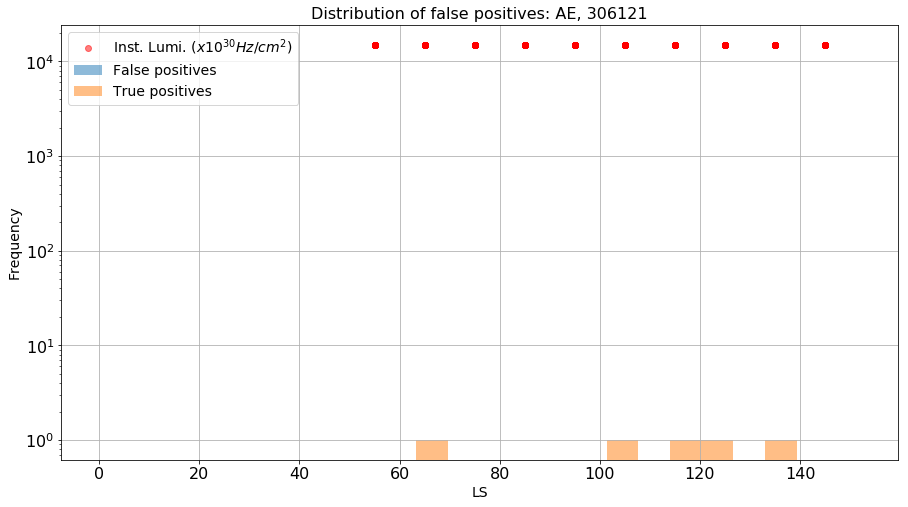

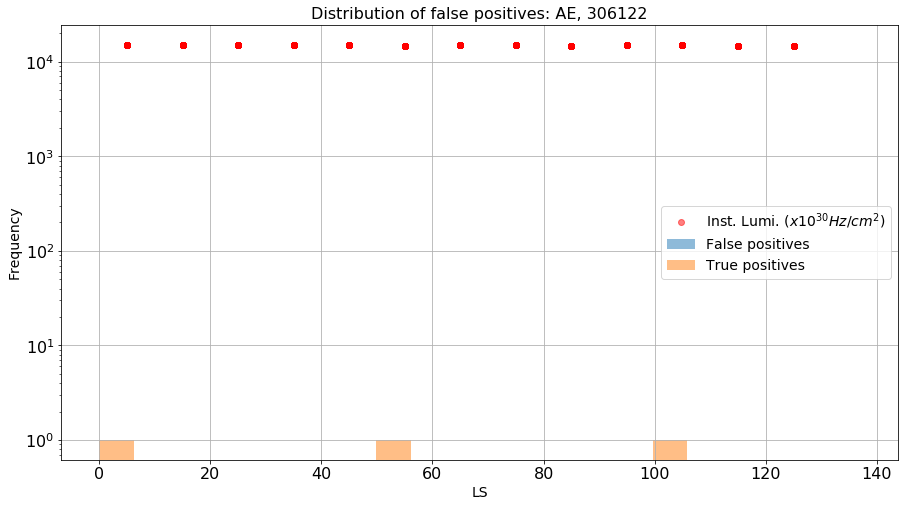

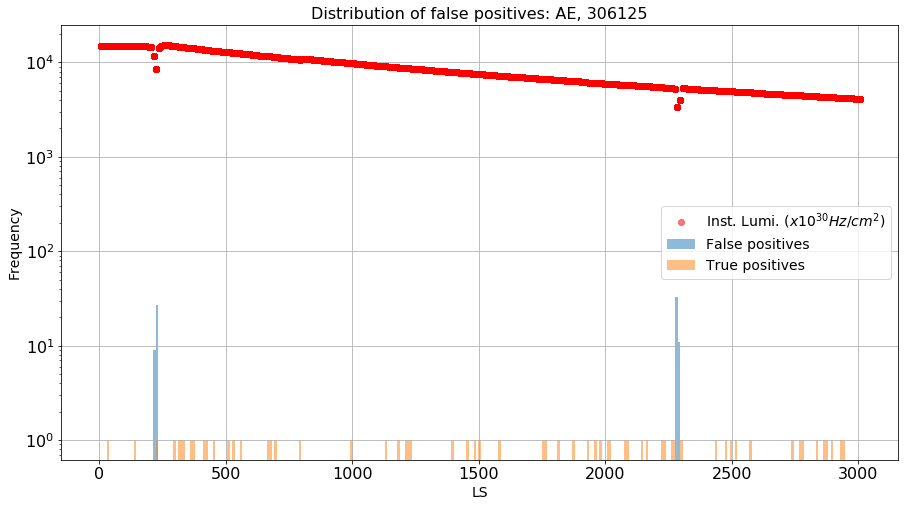

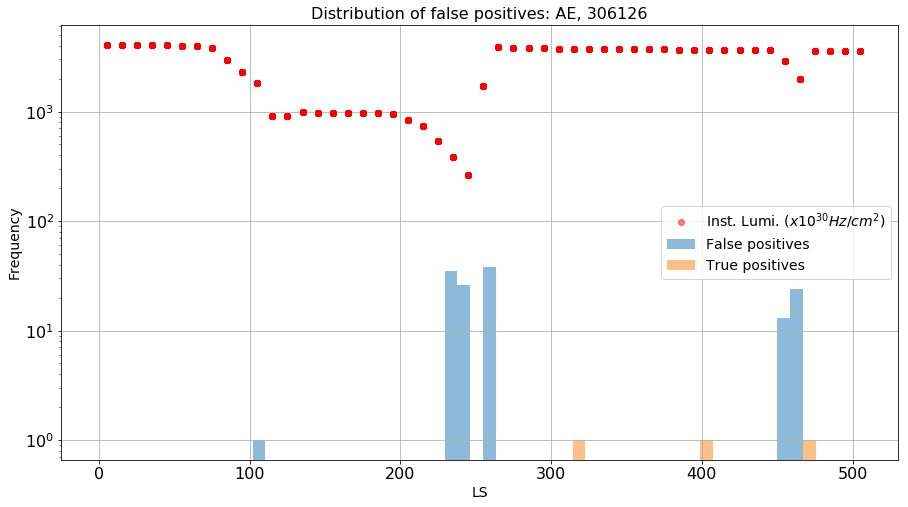

In [205]:
def plotFpVsLs(run, wheel, sector, station, title, df, algo, threshold, log, bound):
    fig, ax = plt.subplots()
    if log:
        ax.set_yscale('log')
    bins = np.linspace(0, bound, int(bound/10)+10)
    (n, bins, patches) = plt.hist(df[(df["score"] == -1) & (df[algo] > threshold)
                         #& (df["wheel"] == 2) &\
                         #& (df["sector"] == 4) &\
                         #& (df["station"] == 2) &\
                         & (df["run"] == run)\
                        ]["averageLS"],
             bins=bins, alpha=0.5, label="False positives")
    plt.hist(df[(df["score"] == 1) & (df[algo] > threshold)
                         #& (df["wheel"] == 2) &\
                         #& (df["sector"] == 4) &\
                         #& (df["station"] == 2) &\
                         & (df["run"] == run)\
                        ]["averageLS"],
             bins=bins, alpha=0.5, label="True positives")
    plt.plot(df[(df["run"] == run)]["averageLS"],\
             df[(df["run"] == run)]["lumi"], "ro",\
             alpha=0.5, label="Inst. Lumi. $(x 10^{30} Hz/cm^2)$")
    plt.title(title+str(run))
    plt.legend(loc='best')
    plt.ylabel('Frequency')
    plt.xlabel('LS')
    plt.grid(True)
    #plt.plot([bound, bound], [0, 100], color='r', linestyle='--', linewidth=2)
    plt.show()
    return n
    
threshold = th_ae
n1 = plotFpVsLs(306121, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score",\
                threshold, True, boundaries[boundaries["run"] == 306121]["ls_end"])
n2 = plotFpVsLs(306122, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score",\
                threshold, True, boundaries[boundaries["run"] == 306122]["ls_end"])
n3 = plotFpVsLs(306125, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score",\
                threshold, True, boundaries[boundaries["run"] == 306125]["ls_end"])
n4 = plotFpVsLs(306126, 0, 0, 0, "Distribution of false positives: AE, ", layers_test, "cae_score",\
                threshold, True, boundaries[boundaries["run"] == 306126]["ls_end"])

Trying some benchmark algorithms (for outlier detection). Isolation forest:

In [209]:
def variance(content):
    return np.var(content)
layers_test["variance_score"] = layers_test["content"].apply(variance)

In [210]:
def cross_validation_split(train_X, train_y, clf_i, param_grid, return_params=False):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=rng)
    clf = GridSearchCV(clf_i, param_grid, cv=skf, scoring='roc_auc'); 
    clf.fit(train_X, train_y)
    if return_params:
        return clf.best_params_
    return clf.best_estimator_

In [211]:
param_grid = [{"max_samples": [100, 1000],
               "n_estimators": [10, 100],
               "contamination": np.array(range(4, 13, 1))/100.0}]

ifparams = cross_validation_split(np.vstack(layers_train["content_scaled"].values),
                                 -layers_train["score"].astype(int),
                                 IsolationForest(random_state=rng, 
                                                 #verbose=1
                                                ),
                                 param_grid)

In [212]:
# Retrain IF using all unlabelled samples

ifclf = IsolationForest(max_samples=ifparams.max_samples,
                        n_estimators=ifparams.n_estimators,
                        contamination=ifparams.contamination,
                        random_state=rng)

ifclf.fit(np.vstack(normalies_train["content_scaled"].values))

IsolationForest(bootstrap=False, contamination=0.040000000000000001,
        max_features=1.0, max_samples=1000, n_estimators=10, n_jobs=1,
        random_state=<mtrand.RandomState object at 0x12b72fc30>, verbose=0)

Then use SVM for outlier detection:

In [213]:
# This may take some time... to be run on a remote machine possibly on GPU

#param_grid = [{"nu": np.array(range(1, 10, 1))/10.0,
#               "gamma": ["auto", 0.1, 0.01, 0.001, 0.0001],
#               "kernel": ["linear", "rbf"]}]

#svmparams = cross_validation_split(np.vstack(layers_train["content_scaled"].values),
#                                  -layers_train["score"].astype(int),
#                                  svm.OneClassSVM(random_state=rng, 
#                                                  verbose=1
#                                                 ),
#                                  param_grid)

In [215]:
# Retrain SVM using only good samples. For the moment using some temporary values.
svmclf = svm.OneClassSVM(
                         #nu=svmparams.nu,
                         nu=0.10000000000000001,
                         #gamma=svmparams.gamma,
                         gamma='auto',
                         kernel='linear',
                         random_state=rng
                        )
svmclf.fit(np.vstack(normalies_train["content_scaled"].values))

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto',
      kernel='linear', max_iter=-1, nu=0.1,
      random_state=<mtrand.RandomState object at 0x12b72fc30>,
      shrinking=True, tol=0.001, verbose=False)

In [216]:
layers_test["svm_score"] = -svmclf.decision_function(np.vstack(layers_test["content_scaled"].values))
layers_test["if_score"] = -ifclf.decision_function(np.vstack(layers_test["content_scaled"].values))

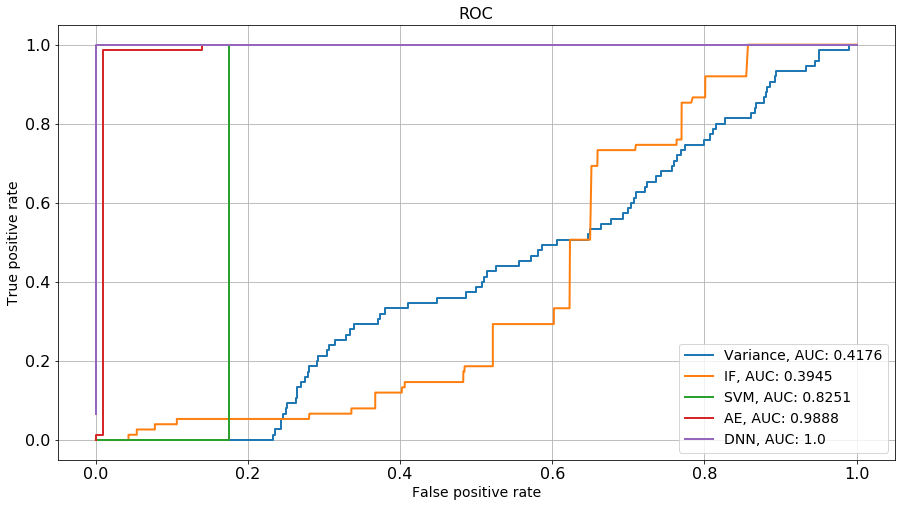

In [217]:
get_roc_curve(layers_test,[
                           ("Variance", "variance_score"),
                           ("IF", "if_score"),
                           ("SVM", "svm_score"),
                           ("AE", "cae_score"),
                           ("DNN", "ann_score_4"),
                          ]
             )

In [218]:
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
bdt_clf = tree.DecisionTreeClassifier()
bdt_clf = bdt_clf.fit(np.vstack(layers_train["content_scaled"].values), layers_train["score"].astype(int))
layers_test["bdt_score"] = bdt_clf.predict(np.vstack(layers_test["content_scaled"].values))

In [219]:
ada_clf = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)
ada_clf = ada_clf.fit(np.vstack(layers_train["content_scaled"].values), layers_train["score"].astype(int))
layers_test["ada_score"] = ada_clf.predict(np.vstack(layers_test["content_scaled"].values))

Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


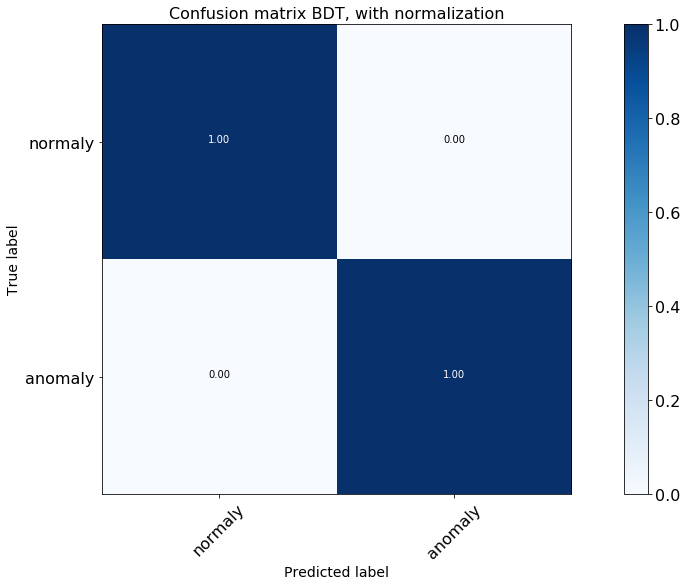

In [220]:
threshold = 0.0
y_pred = 2*(layers_test["bdt_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix BDT, with normalization')

Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


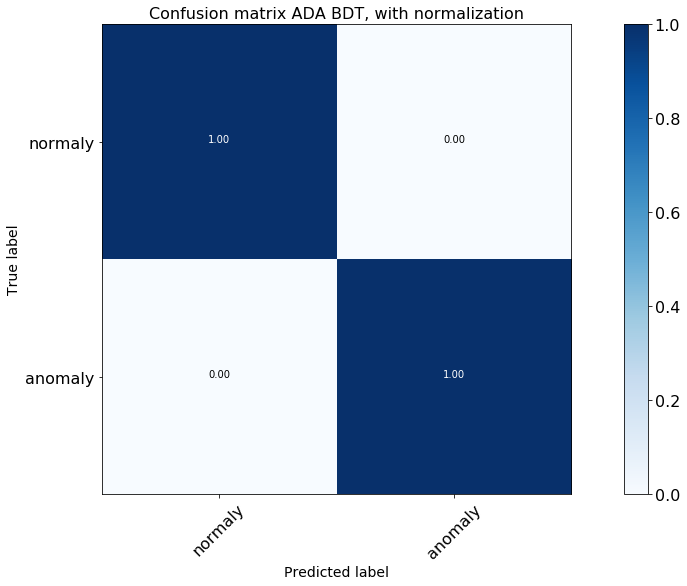

In [221]:
threshold = 0.0
y_pred = 2*(layers_test["ada_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix ADA BDT, with normalization')

Trying KNeighborsClassifier classifier:

In [222]:
from sklearn import neighbors
knclf = neighbors.KNeighborsClassifier(15, weights='distance')
knclf.fit(np.vstack(layers_train["content_scaled"].values),\
          -layers_train["score"].astype(int))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='distance')

In [223]:
layers_test["knn_score"] = -knclf.predict(np.vstack(layers_test["content_scaled"].values))

Normalized confusion matrix
[[ 1.          0.        ]
 [ 0.01333333  0.98666667]]


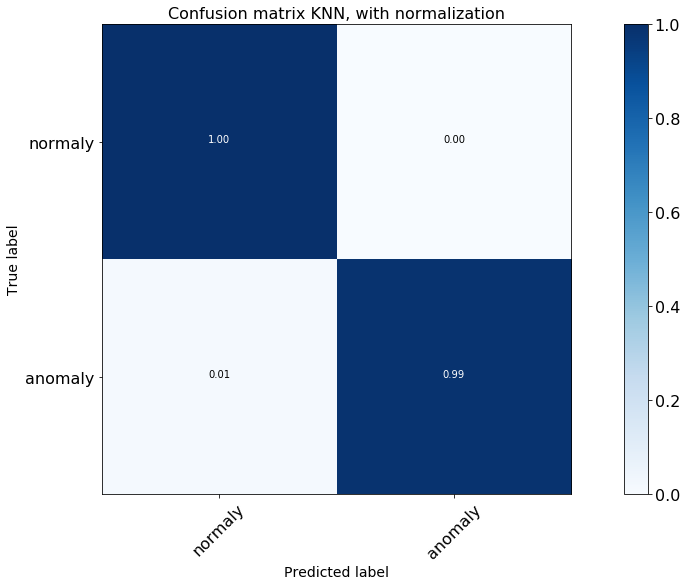

In [224]:
threshold = 0.0
y_pred = 2*(layers_test["knn_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix KNN, with normalization')

In [226]:
filename = './model_sktlearn/knn.sav'
joblib.dump(knclf, filename)

['./model_sktlearn/knn.sav']

Trying unsupervised algorithms: LOF. Optimizing LOF parameters first:

In [232]:
threshold = 0.0
result_lof = []
for i in range(5, 100, 2):
    lofclf = LocalOutlierFactor(n_neighbors=i, contamination=0.02)#It has to be a odd number
    layers_train["lof_score"] = -lofclf.fit_predict(np.vstack(layers_train["content_scaled"].values))
    y_pred = 2*(layers_train["lof_score"] > threshold)-1
    tn, fp, fn, tp = confusion_matrix(layers_train["score"].astype(int), y_pred).ravel()
    result_lof.append([i, tn, fp, fn, tp])

In [233]:
for i in range(105, 1000, 100):
    lofclf = LocalOutlierFactor(n_neighbors=i, contamination=0.02)#It has to be a odd number
    layers_train["lof_score"] = -lofclf.fit_predict(np.vstack(layers_train["content_scaled"].values))
    y_pred = 2*(layers_train["lof_score"] > threshold)-1
    tn, fp, fn, tp = confusion_matrix(layers_train["score"].astype(int), y_pred).ravel()
    result_lof.append([i, tn, fp, fn, tp])

In [234]:
for i in range(1005, 2000, 100):
    lofclf = LocalOutlierFactor(n_neighbors=i, contamination=0.02)#It has to be a odd number
    layers_train["lof_score"] = -lofclf.fit_predict(np.vstack(layers_train["content_scaled"].values))
    y_pred = 2*(layers_train["lof_score"] > threshold)-1
    tn, fp, fn, tp = confusion_matrix(layers_train["score"].astype(int), y_pred).ravel()
    result_lof.append([i, tn, fp, fn, tp])

In [235]:
fp_rate = []
tp_rate = []
for i in range(len(result_lof)):
    fp_rate.append([result_lof[i][0], result_lof[i][2]*1.0/(result_lof[i][1]+result_lof[i][2])])
    tp_rate.append([result_lof[i][0], result_lof[i][4]*1.0/(result_lof[i][3]+result_lof[i][4])])

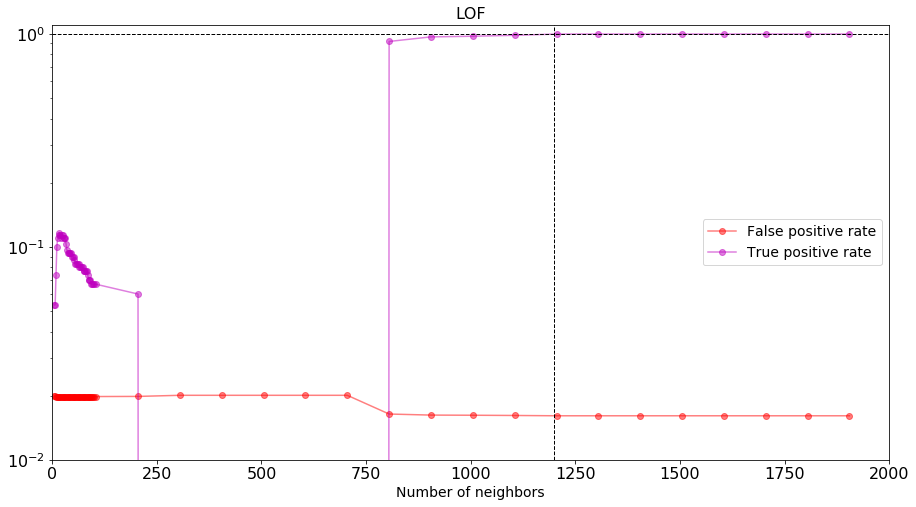

In [239]:
def plot_perf(der, rel, xaxis, yaxis, x1, x2, y1, y2, logx, logy):
    fig, ax = plt.subplots()
    if logy:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')
    a, b = zip(*der)
    c, d = zip(*rel)
    plt.ylim(y1, y2)
    plt.xlim(x1, x2)
    plt.plot(a, b, "ro-", alpha=0.5, label = "False positive rate")
    plt.plot(c, d, "mo-", alpha=0.5, label = "True positive rate")
    plt.axhline(1.00, color='k', linestyle='dashed', linewidth=1)
    #plt.axhline(0.01, color='g', linestyle='dashed', linewidth=1)
    if (xaxis == 'Number of neighbors'):
        plt.axvline(1200, color='k', linestyle='dashed', linewidth=1)
    elif (xaxis == 'Contamination'):
        plt.axvline(0.02, color='k', linestyle='dashed', linewidth=1)
    plt.title("LOF")
    plt.legend(loc='best')
    #plt.ylabel('Inertia')
    plt.xlabel(xaxis)
    plt.show()
    
plot_perf(fp_rate, tp_rate, 'Number of neighbors', '', 0, 2000, 0.01, 1.1, False, True)

In [240]:
threshold = 0.0
result_lof = []
for i in np.array(range(1, 500, 5))/1000.0:
    lofclf = LocalOutlierFactor(n_neighbors=1205, contamination=i)#It has to be a odd number
    layers_train["lof_score"] = -lofclf.fit_predict(np.vstack(layers_train["content_scaled"].values))
    y_pred = 2*(layers_train["lof_score"] > threshold)-1
    tn, fp, fn, tp = confusion_matrix(layers_train["score"].astype(int), y_pred).ravel()
    result_lof.append([i, tn, fp, fn, tp])

In [241]:
fp_rate_c = []
tp_rate_c = []
for i in range(len(result_lof)):
    fp_rate_c.append([result_lof[i][0], result_lof[i][2]*1.0/(result_lof[i][1]+result_lof[i][2])])
    tp_rate_c.append([result_lof[i][0], result_lof[i][4]*1.0/(result_lof[i][3]+result_lof[i][4])])

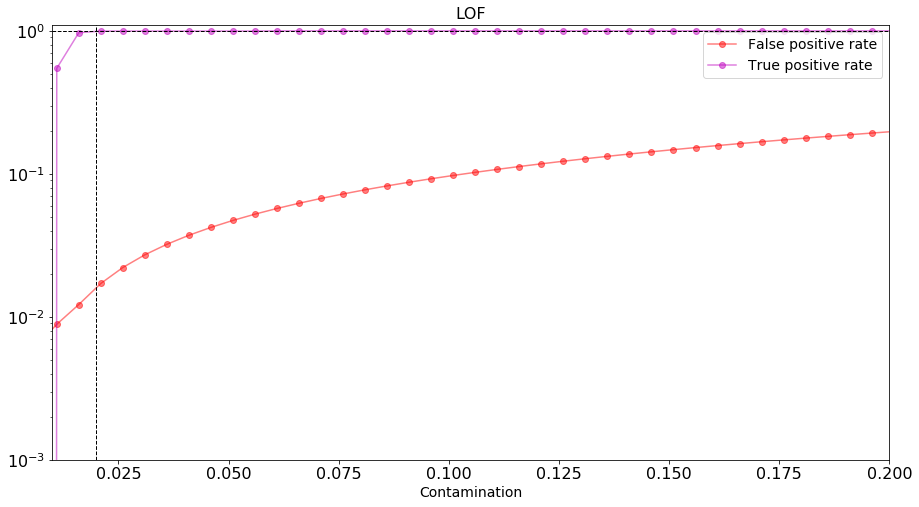

In [242]:
plot_perf(fp_rate_c, tp_rate_c, 'Contamination', '', 0.01, 0.2, 0.001, 1.1, False, True)

Choosing ...

In [244]:
# fit the model
lofclf = LocalOutlierFactor(n_neighbors=1205, contamination=0.02)#It has to be a odd number
layers_train["lof_score"] = -lofclf.fit_predict(np.vstack(layers_train["content_scaled"].values))

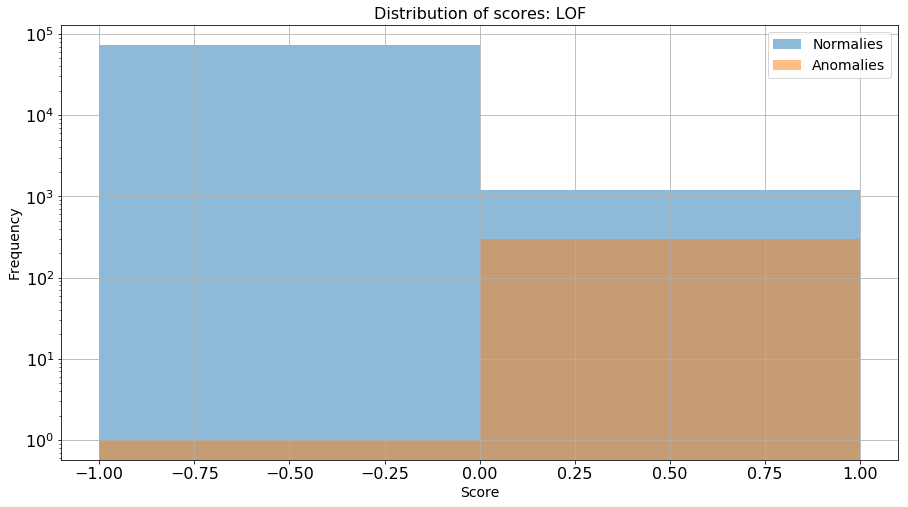

In [245]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(-1, +1, 3)
plt.hist(layers_train[layers_train["score"] < 0]["lof_score"], bins=bins, alpha=0.5, label="Normalies")
plt.hist(layers_train[layers_train["score"] > 0]["lof_score"], bins=bins, alpha=0.5, label="Anomalies")
plt.title("Distribution of scores: LOF")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.show()

Normalized confusion matrix
[[ 0.98390667  0.01609333]
 [ 0.00333333  0.99666667]]


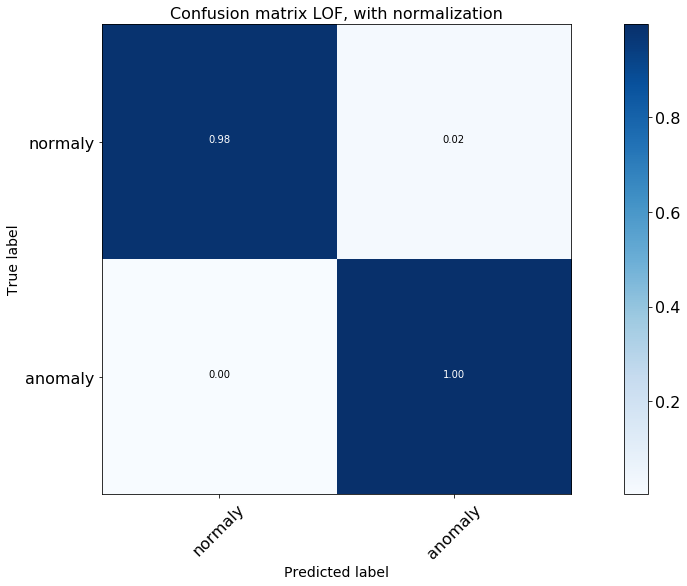

In [246]:
threshold = 0.0
y_pred = 2*(layers_train["lof_score"] > threshold)-1
cnf_matrix = confusion_matrix(layers_train["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix LOF, with normalization')

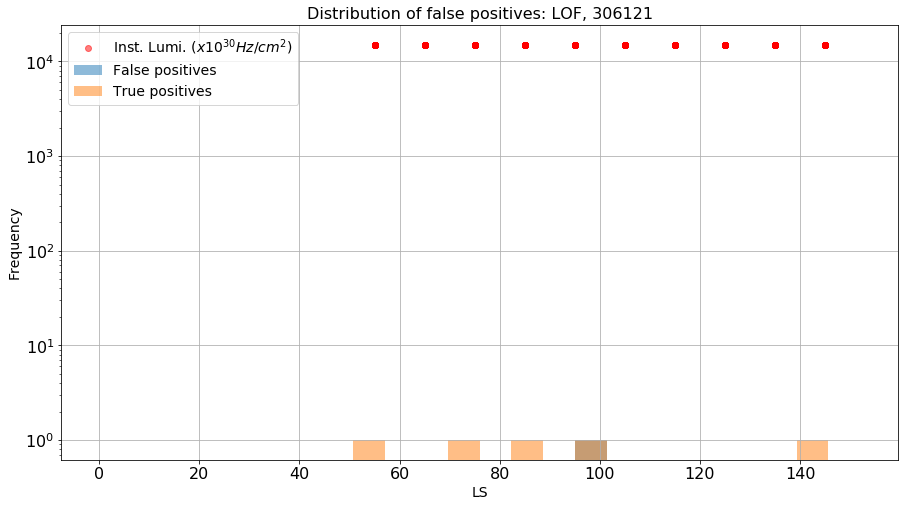

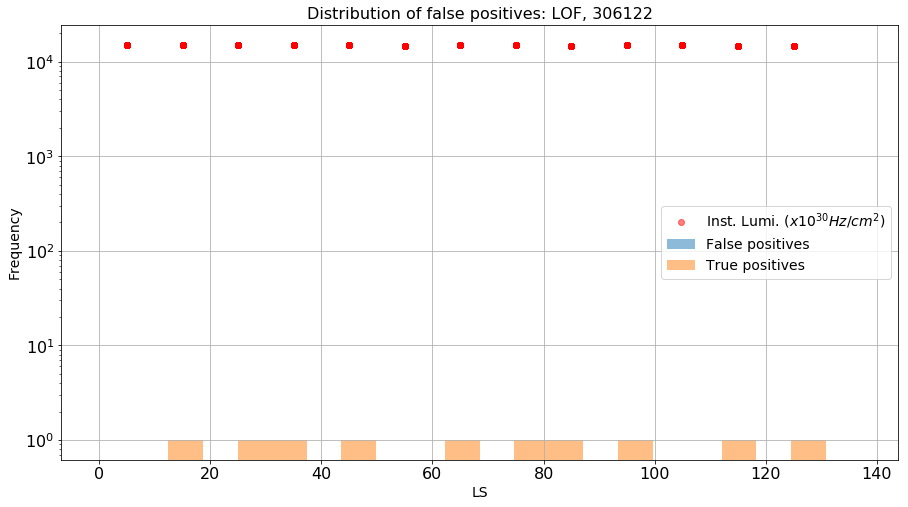

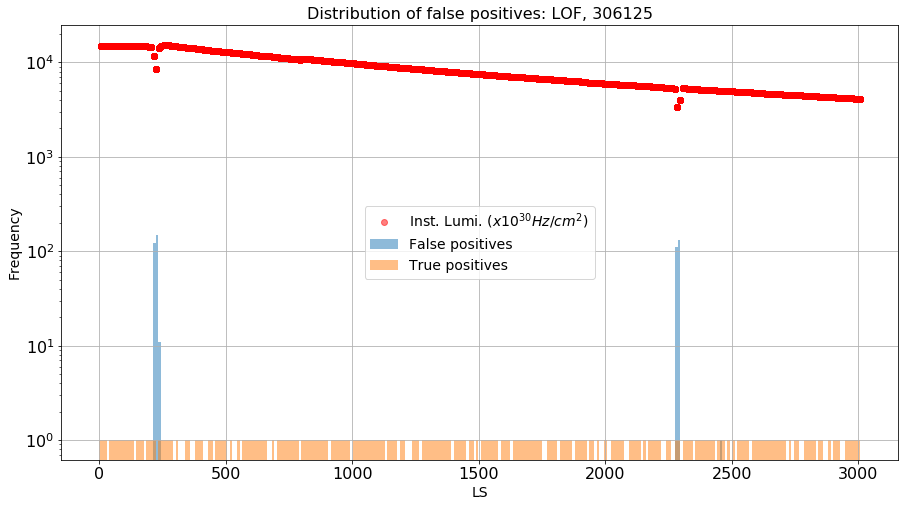

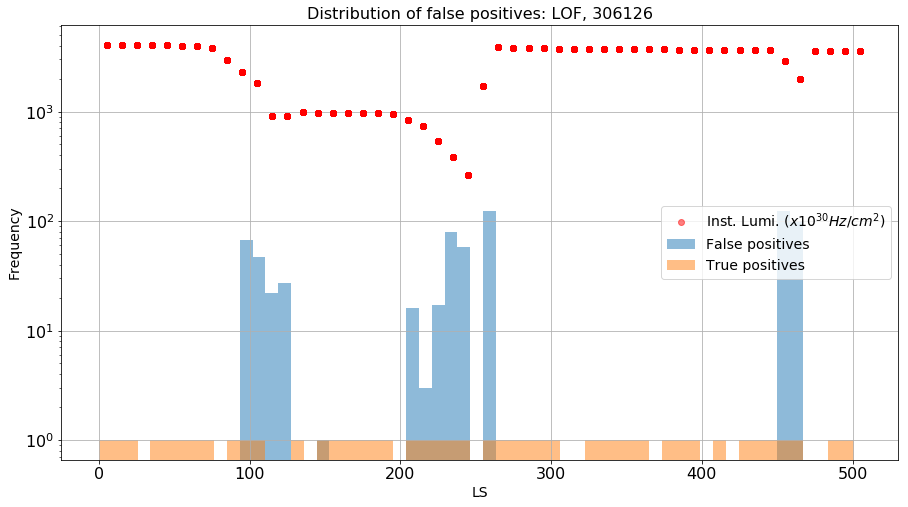

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,   67.,   47.,   22.,   27.,    0.,    0.,    1.,
          0.,    0.,    0.,    0.,    0.,    0.,   16.,    3.,   17.,
         79.,   58.,    0.,  123.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  124.,
         97.,    0.,    0.,    0.,    0.])

In [247]:
layers_train["averageLS"] = layers_train["group"].apply(deduceLS)
threshold = 0.0
plotFpVsLs(306121, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score",\
           threshold, True, boundaries[boundaries["run"] == 306121]["ls_end"])
plotFpVsLs(306122, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score",\
           threshold, True, boundaries[boundaries["run"] == 306122]["ls_end"])
plotFpVsLs(306125, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score",\
           threshold, True, boundaries[boundaries["run"] == 306125]["ls_end"])
plotFpVsLs(306126, 0, 0, 0, "Distribution of false positives: LOF, ", layers_train, "lof_score",\
           threshold, True, boundaries[boundaries["run"] == 306126]["ls_end"])

Trying KMeans clustering algorithm. First of all let's find the optimal number of clusters (parameter to the algorithm) by scanning the average distance vs. number of clusters:

In [ ]:
means = []
for i in range(1, 300, 10):
    print i
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(np.vstack(normalies_train["content_scaled"].values))
    means.append([i, k_means.inertia_])

1
11
21
31
41
51
61
71
81
91
101
111
121
131
141
151
161
171
181
191
201
211
221
231
241
251
261
271
281
291


In [ ]:
for i in range(300, 500, 10):
    print i
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(np.vstack(normalies_train["content_scaled"].values))
    means.append([i, k_means.inertia_])

300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460


In [ ]:
for i in range(500, 1000, 100):
    print i
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(np.vstack(normalies_train["content_scaled"].values))
    means.append([i, k_means.inertia_])

In [ ]:
for i in range(1000, 2000, 200):
    print i
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(np.vstack(normalies_train["content_scaled"].values))
    means.append([i, k_means.inertia_])

In [ ]:
for i in range(2, 10, 1):
    print i
    k_means = cluster.KMeans(n_clusters=i)
    k_means.fit(np.vstack(normalies_train["content_scaled"].values))
    means.append([i, k_means.inertia_])

In [ ]:
def getKey(item):
    return item[0]

means = sorted(means, key=getKey)

In [ ]:
der = []
for i in range(0, len(means)-1):
    x, y = zip(*means)
    a = np.sqrt(y[i]/len(normalies_train))
    b = np.sqrt(y[i+1]/len(normalies_train))
    delta = (a-b)/a
    der.append([x[i], delta])

In [ ]:
rel = []
for i in range(0, len(means)-1):
    x, y = zip(*means)
    a = np.sqrt(y[i]/len(normalies_train))
    b = np.sqrt(y[i+1]/len(normalies_train))
    delta = (a-b)*100000/y[0]
    rel.append([x[i], delta])

In [ ]:
def plotDist(means, der, rel):
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    ax.set_xscale('log')
    x, y = zip(*means)
    a, b = zip(*der)
    c, d = zip(*rel)
    plt.ylim(0.0001, 10.)
    plt.xlim(1, 2000)
    plt.plot(x, np.sqrt(np.array(y)/len(normalies_train)), "bo-", alpha=0.5, label="Average distance")
    plt.plot(a, b, "ro-", alpha=0.5, label = "Relative variation: (d$_{cls}$ - d$_{cls+1}$)/d$_{cls}$")
    plt.plot(c, d, "mo-", alpha=0.5, label = "Relative variation: (d$_{cls}$ - d$_{cls+1}$)/d$_{cls = 1}$\
    (x$10^{-5}$)")
    plt.axhline(0.05, color='k', linestyle='dashed', linewidth=1)
    plt.axhline(0.01, color='g', linestyle='dashed', linewidth=1)
    plt.axvline(100, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(500, color='y', linestyle='dashed', linewidth=1)
    plt.title("K-Means clustering")
    plt.legend(loc='best')
    #plt.ylabel('Inertia')
    plt.xlabel('Number of clusters')
    plt.show()
    
plotDist(means, der, rel)

Choosing 450 clusters and training on the normalies only:

In [384]:
n_cls = 450
k_means = cluster.KMeans(n_clusters=n_cls)
distances = k_means.fit_transform(np.vstack(normalies["content_scaled"].values))
normalies["kmeans_score"] = k_means.labels_

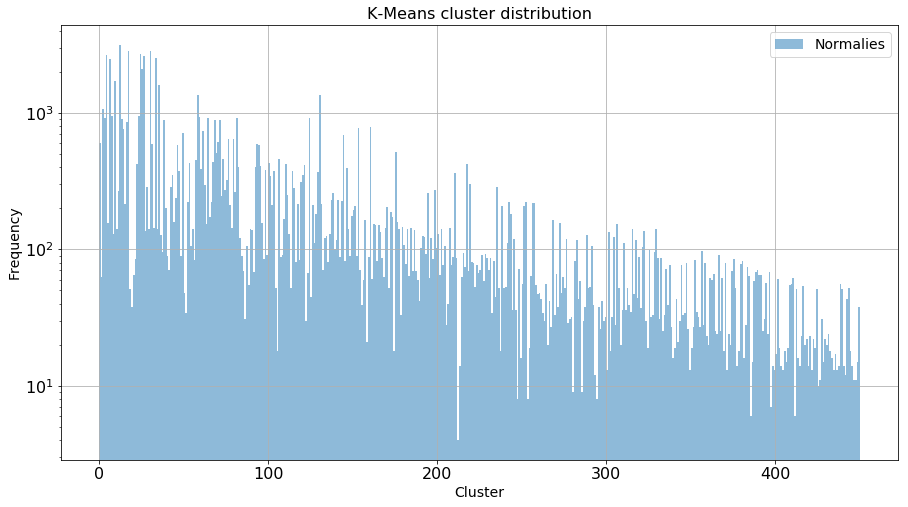

In [385]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, n_cls, n_cls+1)
plt.hist(normalies[normalies["score"] < 0]["kmeans_score"], bins=bins, alpha=0.5, label="Normalies")
#plt.hist(normalies[normalies["score"] > 0]["kmeans_score"], bins=bins, alpha=0.5, label="Anomalies")
plt.title("K-Means cluster distribution")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Cluster')
plt.show()

The minimal distance is used to assign the data to the clusters. Visualize the average distance within a cluster:

In [386]:
minim = []
for i in range(0, len(distances)):
    #print  min(distances[i])
    minim.append(min(distances[i]))

In [387]:
#print len(minim)
normalies["dist"] = minim
#print normalies["dist"]

In [388]:
temp1 = normalies.groupby(["kmeans_score"])[["dist"]].mean().reset_index()        

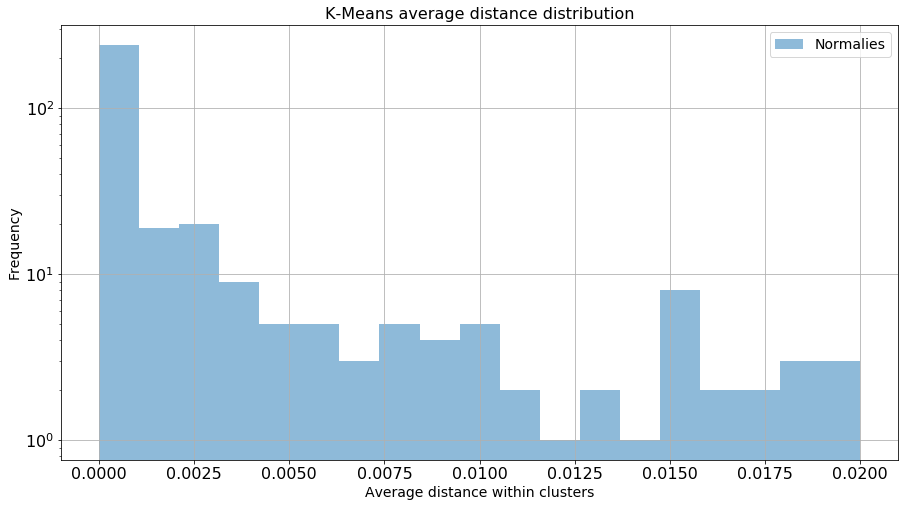

In [389]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.grid()
bins = np.linspace(0, 0.02, 20)
plt.hist(temp1["dist"], bins=bins, alpha=0.5, label="Normalies")
plt.title("K-Means average distance distribution")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Average distance within clusters')
plt.show()

Predicting the distances of the test sample data with respect to the clusters and plotting the minimum distance for each point (dividing anomalies and normalies):

In [390]:
distances_test = k_means.transform(np.vstack(layers_test["content_scaled"].values))
minim = []
for i in range(0, len(distances_test)):
    #print  min(distances_test[i])
    minim.append(min(distances_test[i]))
layers_test["dist"] = minim

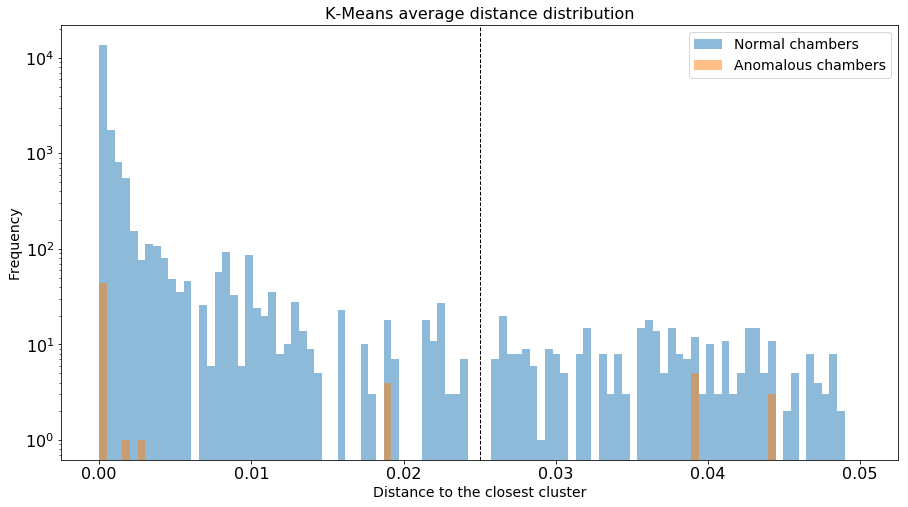

In [391]:
fig, ax = plt.subplots()
ax.set_yscale('log')
#ax.grid()
bins = np.linspace(0, 0.05, 100)
plt.hist(layers_test[layers_test["score"] < 0]["dist"], bins=bins, alpha=0.5, label="Normal chambers")
plt.hist(layers_test[layers_test["score"] > 0]["dist"], bins=bins, alpha=0.5, label="Anomalous chambers")
plt.axvline(0.025, color='k', linestyle='dashed', linewidth=1)
plt.title("K-Means average distance distribution")
plt.legend(loc='best')
plt.ylabel('Frequency')
plt.xlabel('Distance to the closest cluster')
plt.show()

Normalized confusion matrix
[[ 0.96437333  0.03562667]
 [ 0.66666667  0.33333333]]


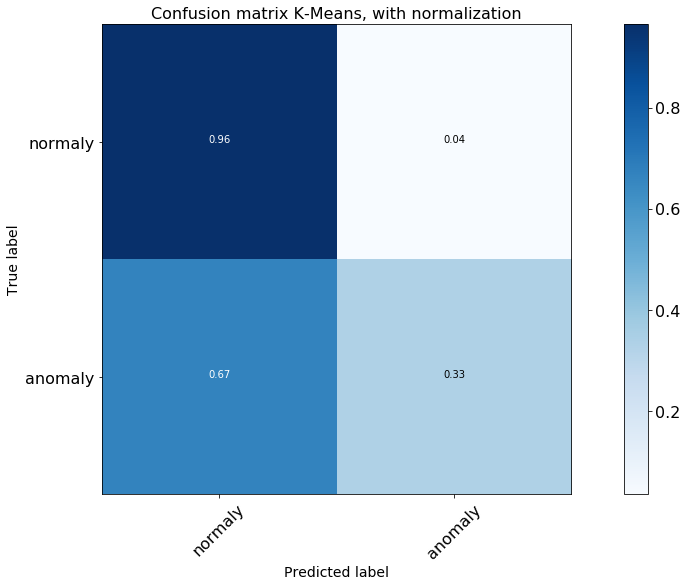

In [392]:
th_km = 0.025
y_pred = 2*(layers_test["dist"] > th_km)-1
cnf_matrix = confusion_matrix(layers_test["score"].astype(int), y_pred)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["normaly","anomaly"], normalize=True,
                      title='Confusion matrix K-Means, with normalization')

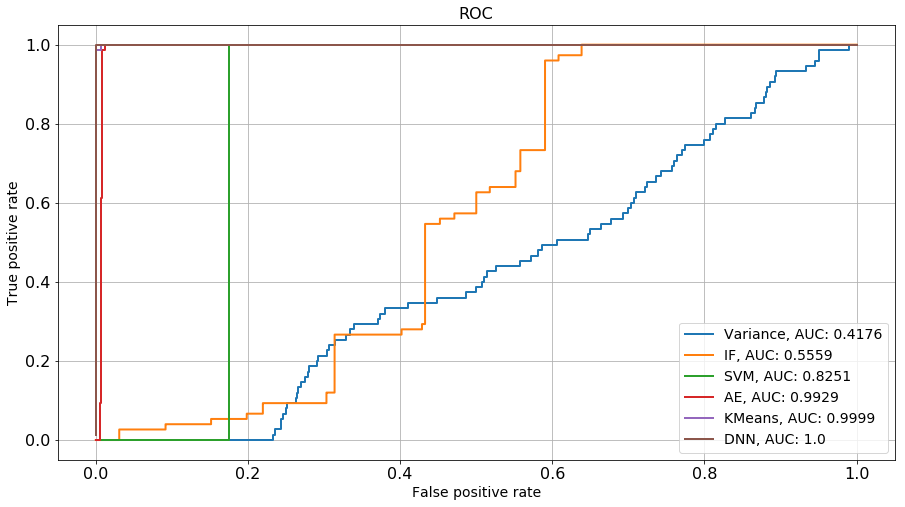

In [345]:
get_roc_curve(layers_test,[
                           ("Variance", "variance_score"),
                           ("IF", "if_score"),
                           ("SVM", "svm_score"),
                           ("AE", "cae_score"),
                           ("KMeans", "dist"),
                           ("DNN", "ann_score_4"),
                          ]
             )

In [346]:
filename = './model_sktlearn/kmeans.sav'
joblib.dump(k_means, filename)

['./model_sktlearn/kmeans.sav']